# Progetto di Classificazione di Forme Geometriche da Sequenze di Punti

# Chiappini Mario 0322135

## Obiettivo del progetto

Lo scopo di questo progetto è sviluppare un sistema automatico in grado di riconoscere forme geometriche semplici - ellissi, rettangoli, segmenti e coppie di segmenti che si incrociano in modo ortogonale, a croce - a partire da sequenze di punti che ne rappresentano il contorno.

## Dataset
Il dataset viene calcolato in modo sintetico per mezzo della funzione _genera_campioni_, che determina una sequenza di punti per ogni forma, aggiungendo un eventuale rumore gaussiano.
Si consideri inizialmente un dataset composto da **4000 forme** (1000 per tipo) ognuna descritta da 100 punti, ordinati secondo l'ordine di generazione dell'algoritmo utilizzato, con associato il relativo target, sotto forma di un intero tra 0 e 3, associato a una label per la forma dalla lista labels. 


200 valori rappresenta un campione etichettato costituito da una sequenza di numeri in vergola mobile $x_1\ y_1\ x_2\ y_2\ \ldots x_{100}\ y_{100}$ che rappresentano le $200$ coordinate dei $100$  punti che descrivono il perimetro della forma, seguita da una etichetta testuale (ellisse, rettangolo, segmento, croce) che indica la forma rappresentata.

## Compiti dello studente

Lo studente dovrà progettare un **classificatore automatico** in grado di riconoscere correttamente la forma rappresentata da ciascuna sequenza. Il progetto richiede di affrontare i seguenti step:

### 1. Rappresentazione e feature engineering
Definire una rappresentazione vettoriale delle forme implementando la funzione _ottieni_features_. Nel codice, viene fornita una implementazione di tale funzione corrispondente ad una banale rappresentazione in cui l'insieme di punti $(x_1,y_1), \ldots, (x_n, y_n)$ è rappresentato da un vettore $x_1,y_1, \ldots,x_n, y_n$. Si valuti l'utilizzo di rappresetazioni diverse sia utilizzando metodi algoritmici (feature selection, feature extraction) che definendo nuove features (es. distanza dal centroide, perimetro e distanza tra punti estremi, etc.).

### 2. Costruzione e valutazione di classificatori

- Utilizzare le caratteristiche estratte per addestrare e confrontare un insieme di classificatori, valutando anche il valore ottimo (o sufficientemente buono) di iperparametri definiti per il classificatore considerato (model selection), utilizzano un validation set o la cross-validation
- Valutare le prestazioni dei vari modelli su un test set anch'esso sintetico, derivato dal dataset calcolato mediante splitting o anche prodotto utilizzando il medesimo algoritmo.
- Esaminare e confrontare le prestazioni ottenute sul training e sul test set e controllare l'eventaule overfitting

### 3. Test di robustezza
Analizzare l'effetto sulle prestazioni ottenute dai vari modelli, e su quelle del miglior classificatore di
- Quantità di forme disponibili come esempio
- Numero di punti che descrivono la singola forma
- Quantità di rumore gaussiano
Analizzare inoltre la differenza di prestazioni al variare del dataset considerato, prodotto comunque secondo il medesimo algoritmo.

### 4. Classificazione binaria
Considerare il problema di classificazione binaria derivato considerando la classe delle forme con area nulla (segmento, croce) vs. la classe di quelle ad area positiva (ellisse, rettangolo), unendo quindi da un lato le classi 0 e 1 e dall'altro le classi 2,3. Analizzare le prestazioni ottenute sul problema secondo le indicazioni precedenti.

In [51]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.spatial import ConvexHull, QhullError
from scipy.spatial.distance import pdist
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay

print("import fatto!")

import fatto!


In [52]:
def to_stringa(punti, forma):
    return ";".join(f"{x:.3f}:{y:.3f}" for x, y in punti)+','+forma

def print_forma(n, X, y, labels):
    for x_i, y_i in zip(X[:n], y[:n]):
        print(to_stringa(x_i, labels[y_i]))
        
def plot_shape(X, y, labels):
    """
    Mostra una shape rappresentativa per ciascuna classe presente in y.

    Args:
        X (list of np.ndarray): lista di array (uno per forma) di shape (n_punti, 2)
        y (np.ndarray): array di interi con le etichette corrispondenti alle forme
        labels (list of str): nomi delle etichette per le forme
    """
    classi = np.unique(y)
    num_classi = len(classi)

    fig, axs = plt.subplots(1, num_classi, figsize=(4 * num_classi, 4))

    if num_classi == 1:
        axs = [axs]  # Assicura che axs sia sempre iterabile
    
    for i, etichetta in enumerate(classi):
        idx = np.where(y == etichetta)[0][0]  # Primo esempio con quell'etichetta
        shape = X[idx]
        ax = axs[i]

        ax.plot(shape[:, 0], shape[:, 1], color='C' + str(etichetta))
        ax.set_title(f"Classe {etichetta}: {labels[etichetta].capitalize()}")
        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        ax.axis("equal")
        ax.grid(True)

    plt.tight_layout()
    plt.suptitle("Una forma per ciascuna classe", fontsize=16, y=1.05)
    plt.show()



def genera_segmento(x0, y0, theta, l, n_punti=50, rumore_std = 0.01):
    """
    Genera un segmento rettilineo con n_punti, tra due estremi calcolati a partire da un punto centrale (x0, y0),
    una lunghezza totale l e un angolo theta rispetto all'asse x. I punti sono distribuiti uniformemente lungo il segmento,
    con l'aggiunta opzionale di rumore gaussiano.

    Args:odel selection), utilizzano un validation set o la cross-validation
- Valutare le prestazioni dei vari modelli su un test set anch'esso sintetico, 
        x0 (float): coordinata x del punto centrale del segmento
        y0 (float): coordinata y del punto centrale del segmento
        theta (float): angolo del segmento rispetto all'asse x (in radianti)
        l (float): metà lunghezza del segmento (il segmento totale sarà lungo 2*l)
        n_punti (int): numero di punti da generare lungo il segmento
        rumore_std (float): deviazione standard del rumore gaussiano da aggiungere ai punti

    Returns:
        np.ndarray: array di shape (n_punti, 2) contenente le coordinate dei punti generati
    """
    # Calcola le coordinate dei due estremi del segmento
    x1 = x0 + l * np.cos(theta)
    y1 = y0 + l * np.sin(theta)
    x2 = x0 - l * np.cos(theta)
    y2 = y0 - l * np.sin(theta)
    # Interpolazione lineare tra i due estremi per ottenere i punti
    t = np.linspace(0, 1, n_punti) # n valori tra 0 - 1
    x = x1 + t * (x2 - x1)
    y = y1 + t * (y2 - y1)
    # Aggiunta di rumore gaussiano alle coordinate
    x += np.random.normal(0, rumore_std, size=n_punti)
    y += np.random.normal(0, rumore_std, size=n_punti)
    # Restituisce un array Nx2 con i punti generati
    return np.stack([x, y], axis=1)  # shape: (n_punti, 2)

def genera_croce(x0, y0, theta, l, n_punti=50, rumore_std = 0.01):
    """
    Genera una croce composta da due segmenti ortogonali che si intersecano nel punto (x0, y0).
    Ogni segmento è centrato in (x0, y0), ha lunghezza totale 2*l e angolo theta (il secondo segmento è ruotato di 90° rispetto al primo).
    I punti sono distribuiti uniformemente lungo i segmenti, con aggiunta opzionale di rumore gaussiano.

    Args:
        x0 (float): coordinata x del centro della croce
        y0 (float): coordinata y del centro della croce
        theta (float): angolo del primo segmento rispetto all'asse x (in radianti)
        l (float): metà lunghezza di ciascun segmento (ogni segmento è lungo 2*l)
        n_punti (int): numero totale di punti da generare (divisi equamente tra i due segmenti)
        rumore_std (float): deviazione standard del rumore gaussiano da aggiungere ai punti

    Returns:
        np.ndarray: array di shape (n_punti, 2) contenente le coordinate dei punti generati
    """
    # Primo segmento (angolo theta)
    x1 = x0 + l * np.cos(theta)
    y1 = y0 + l * np.sin(theta)
    x2 = x0 - l * np.cos(theta)
    y2 = y0 - l * np.sin(theta)
    t = np.linspace(0, 1, n_punti//2)
    x = x1 + t * (x2 - x1)
    y = y1 + t * (y2 - y1)
    x += np.random.normal(0, rumore_std, size=n_punti//2)
    y += np.random.normal(0, rumore_std, size=n_punti//2)

    # Secondo segmento (angolo theta + 90°)
    x1 = x0 - l * np.sin(theta)
    y1 = y0 + l * np.cos(theta)
    x2 = x0 + l * np.sin(theta)
    y2 = y0 - l * np.cos(theta)
    t = np.linspace(0, 1, n_punti//2)
    xx = x1 + t * (x2 - x1)
    yy = y1 + t * (y2 - y1)
    xx += np.random.normal(0, rumore_std, size=n_punti//2)
    yy += np.random.normal(0, rumore_std, size=n_punti//2)

    # Unisce i punti dei due segmenti
    x = np.concatenate([x, xx])
    y = np.concatenate([y, yy])

    return np.stack([x, y], axis=1)  # shape: (n_punti, 2)



def genera_ellisse(a=1.0, b=0.5, centro=(0, 0), angolo=0.0, n_punti=100, rumore_std=0.0):
    """
    Genera punti su un'ellisse centrata in `centro`, con semiassi `a` e `b`,
    ruotata di `angolo` radianti, e opzionalmente con rumore gaussiano.

    Parametri:
    - a (float): semiasse maggiore
    - b (float): semiasse minore
    - centro (tuple): coordinate del centro (x0, y0)
    - angolo (float): rotazione in radianti (es. np.pi/4 per 45°)
    - n_punti (int): numero di punti da generare
    - rumore_std (float): deviazione standard del rumore gaussiano da aggiungere

    Ritorna:
    - array Nx2 con i punti [x, y]
    """
    
    t = np.linspace(0, 2 * np.pi, n_punti)
    x = a * np.cos(t)
    y = b * np.sin(t)

    # Rotazione
    x_rot = x * np.cos(angolo) - y * np.sin(angolo)
    y_rot = x * np.sin(angolo) + y * np.cos(angolo)

    # Traslazione
    x_finale = x_rot + centro[0]
    y_finale = y_rot + centro[1]

    # Rumore
    x_finale += np.random.normal(0, rumore_std, size=n_punti)
    y_finale += np.random.normal(0, rumore_std, size=n_punti)

    return np.stack([x_finale, y_finale], axis=1)


def genera_rettangolo(larghezza=1.0, altezza=0.5, centro=(0, 0), angolo=0.0,
            rumore_std=0.0, n_punti=100):
    """
    Genera punti distribuiti lungo i 4 lati di un rettangolo ruotato e centrato,
    in modo proporzionale alla lunghezza dei lati.

    Args:
        larghezza (float): larghezza del rettangolo
        altezza (float): altezza del rettangolo
        centro (tuple): centro (x, y)
        angolo (float): rotazione in radianti
        rumore_std (float): rumore gaussiano (std dev)
        n_punti (int): numero totale di punti da generare

    Returns:
        np.ndarray: array (n_punti, 2) con i punti lungo i lati
    """
    if n_punti < 4:
        raise ValueError("n_punti deve essere almeno 4")

    # Vertici base
    w, h = larghezza / 2, altezza / 2
    vertici = np.array([
        [-w, -h],
        [ w, -h],
        [ w,  h],
        [-w,  h]
    ])

    # Lati e lunghezze
    lati = [(vertici[(i+1) % 4] - vertici[i]) for i in range(4)]
    lunghezze = np.array([np.linalg.norm(l) for l in lati])
    proporzioni = lunghezze / lunghezze.sum()

    # Distribuzione dei punti
    n_per_lato = np.floor(proporzioni * n_punti).astype(int)
    restante = n_punti - n_per_lato.sum()
    for i in range(restante):
        n_per_lato[i % 4] += 1

    # Generazione dei punti
    punti = []
    for i, n in enumerate(n_per_lato):
        start = vertici[i]
        end = vertici[(i + 1) % 4]
        t_values = np.linspace(0, 1, n, endpoint=False)
        lato = np.outer(1 - t_values, start) + np.outer(t_values, end)
        punti.append(lato)
    punti = np.vstack(punti)

    # Rotazione, traslazione e rumore
    R = np.array([
        [np.cos(angolo), -np.sin(angolo)],
        [np.sin(angolo),  np.cos(angolo)]
    ])
    punti = punti @ R.T
    punti += np.array(centro)
    punti += np.random.normal(0, rumore_std, punti.shape)

    return punti

## Calcolo di ulteriori features

1. **Calcolo del Centroide (Baricentro) e Misura delle Distanze dal Centroide**

Per arricchire il nostro set di dati, introduciamo nuove feature che descrivono la struttura interna di ogni forma. L'idea è analizzare come i punti di una figura si distribuiscono attorno al suo centroide, ovvero il suo baricentro geometrico.

Per prima cosa, identifichiamo il centroide (C) di una forma, calcolando la media delle coordinate di tutti i suoi punti $(x_i,y_i)$. Matematicamente:

$$C = \left(\frac{1}{n}\sum_{i=1}^n x_i,\ \frac{1}{n}\sum_{i=1}^n y_i\right)$$

Una volta trovato il centroide, calcoliamo la distanza euclidea di ogni punto $P = (p_x, p_y)$ della forma da questo centro.

$$d(P, C) = \sqrt{(p_x - c_x)^2 + (p_y - c_y)^2}$$

Questo processo ci fornisce un insieme di valori (le distanze) che rappresenta una vera e propria "firma" geometrica della figura.

Da questo insieme di distanze, estraiamo delle statistiche chiave che diventano le nostre nuove feature:

- Distanza Media: Indica quanto, in media, i punti si allontanano dal centro.

- Varianza delle Distanze: Misura quanto le distanze sono omogenee. Una varianza bassa suggerisce una forma regolare e tondeggiante, mentre una varianza alta indica la presenza di angoli, vertici o ramificazioni.

- Distanza Massima e Minima: Identificano rispettivamente il punto più lontano e quello più vicino al centro, fornendo informazioni sull'estensione e sulla presenza di un "nucleo" centrale.

L'intuizione dietro queste feature:

- Ellisse: I punti si distribuiscono in modo molto regolare attorno al centro. Le loro distanze avranno una varianza contenuta e una distribuzione uniforme.
- Rettangolo: Le distanze avranno una distribuzione bimodale: un gruppo di distanze minori per i punti sui lati e un gruppo di distanze maggiori per i punti sui vertici. Questo genera una varianza più elevata.
- Segmento: Le distanze crescono linearmente dal centro verso le estremità. La distribuzione sarà molto compressa e orientata lungo un'unica direzione.
- Croce: È la forma con la firma più complessa. La presenza di quattro "bracci" crea una notevole variazione nelle distanze, con alcuni punti vicini al centro e altri molto lontani in direzioni diverse, risultando nella varianza più alta.


In [53]:
def calcola_centroidi(X):
    """
    Calcola il centroide di una forma geometrica

    Parametri:
        X (np.ndarray): Array di shape, contenente i punti delle forme.
        
    Restituisce:
        centroidi (np.ndarray): Array di float, per ogni forma i punti corrispondenti del centroide
    """
    
    centroidi = []
    
    for xi in X:
        centroidi.append(xi.mean(axis=0))

    return np.array(centroidi)

def calcola_distanza_centroide(X):
    """
    Calcola per ogni punto di ciascun forma la distanza dal relativo centroide
    
    Parametri:
        X (np.ndarray): Array di shape, contenente i punti delle forme.
    
    Restituisce:
        distanze (np.ndarray): Array di shape, per ogni forma il relativo array delle distanze dal centroide
    """
    
    distanze = []
    centroidi = calcola_centroidi(X)
    
    for xi, ci in zip(X, centroidi):
        distanze.append(np.linalg.norm(xi - ci, axis=1))

    return np.array(distanze)

def calcola_statistiche_centroide(distanze):
    """
    Calcola per ciascuna forma, la media, deviazione standard e massimo e minimo delle distanze.
    
    Parametri:
        distanze (np.ndarray): Array di shape, per ogni forma il relativo array delle distanze dal centroide
    
    Restituisce:
        stats (np.ndarray): Array di shape
    """
    
    mean = np.mean(distanze, axis=1).reshape(-1 ,1)
    std = np.std(distanze, axis=1).reshape(-1 ,1)
    M = np.max(distanze, axis=1).reshape(-1 ,1)
    m = np.min(distanze, axis=1).reshape(-1 ,1)
    
    stats = np.hstack([mean, std, M, m])
    
    return stats
    

2. **Area, Area Convessa e Rapporto di Solidità**

- Area (A): È la superficie piana racchiusa dal contorno della figura. Per un poligono definito da una sequenza di vertici, la calcoliamo con la formula dell'area di Gauss (Shoelace formula):

$$A = \frac{1}{2} \left| \sum_{i = 1}^{n} \left( x_i y_{i+1} - x_{i+1} y_i \right) \right|$$


- Area Convessa ($A_c$): È l'area dell'inviluppo convesso (convex hull), ovvero la più piccola figura convessa che può contenere tutti i punti della forma. Per calcolarla, ci affidiamo a librerie ottimizzate come scipy. Per definizione, si ha sempre $A_c ≥ A$.

- Il Concetto di "Solidità"

Il rapporto tra queste due aree è un indicatore di compattezza estremamente potente, spesso chiamato "solidità" o "rapporto di convessità":
$$Solidità = \frac{A}{A_c}$$

- Se $A \approx A_c$, la figura è quasi convessa e piana (cerchi, elissi, rettangoli).
- Se $A << A_c$, la figura è frastagliata, ha rientranze o è sparsa (croci).


In [54]:
def calcola_area(X):
    """
    Calcola l'area di ciascuna forma.

    Parametri:
        X (np.ndarray): Array di shape, contenente i punti delle forme.
    
    Restituisce:
        aree (np.ndarray): array di float, nella i-esima posizione contiene l'area della i-esima forma
    """
    
    aree = []

    for xi in X:
        x = xi[:, 0]
        y = xi[:, 1]

        a = 0.5 * np.abs(np.dot(x, np.roll(y, 1)) - np.dot(y, np.roll(x, 1))) # formula di gauss
        aree.append(a)

    return np.array(aree)

def calcola_area_convessa(X):
    """
    Calcola l'area convessa di ciascuna forma.

    Parametri:
        X (np.ndarray): Array di shape, contenente i punti delle forme.

    Restituisce:
        aree (np.ndarray): array di float, nella i-esima posizione contiene l'area convessa della i-esima forma
    """

    aree = []
    for xi in X:
        try:
            hull = ConvexHull(xi)
            area_convessa = hull.volume
            aree.append(area_convessa)
        except QhullError:
            aree.append(0)

    return np.array(aree)

def calcola_rapporto_aree(area, area_convessa):
    """
    Calcola il rapporto tra di ciascuna forma.

    Parametri:
        area (np.ndarray): Array di float, contenente le aree di ciascuna forma.
        area_convessa (np.ndarray): Array di float, contenente le aree convesse di ciascuna forma.

    Restituisce:
        rapporto (np.ndarray): array di float, nella i-esima posizione contiene il rapport tra area e area convessa
    """
    
    # Sostituisce gli zeri in area_convessa con un valore piccolo vicino a zero per evitare divisioni per zero
    area_convessa = np.where(area_convessa == 0, 1e-8, area_convessa)
    rapporto = area / area_convessa 
    
    return rapporto

3. **Perimetro**

Il perimetro è la misura della lunghezza totale del contorno che racchiude una figura geometrica piana. In parole semplici, rappresenta il "cammino" che si deve percorrere per fare un giro completo lungo i bordi della figura.

Il suo calcolo varia in base alla forma:

Per i poligoni (come quadrati, rettangoli o triangoli), il perimetro si ottiene semplicemente sommando la lunghezza di tutti i suoi lati.
Per le figure con contorni curvi, come un cerchio, il perimetro prende il nome di circonferenza e si calcola con la formula $C = 2πr$.

**Calcolo del Perimetro con NumPy**

L'idea di base rimane la stessa: sommare le lunghezze dei segmenti tra punti consecutivi. Con NumPy, possiamo eseguire questa operazione su tutti i punti simultaneamente.

In [55]:
def calcola_perimetro(X):
    """
    Calcola il perimetro di ciascuna forma

    Parametri:
        X (np.ndarray): Array di shape, contenente i punti delle forme.

    Restituisce:
        perimetro (np.ndarray): array di float, nella i-esima posizione contiene il perimetro della i-esima forma
    """
    perimetro = []
    for xi in X:
        p = np.sum(np.linalg.norm(np.diff(xi, axis=0, append=[xi[0]]), axis=1))
        perimetro.append(p)
    
    return np.array(perimetro)

4. **Distanza tra punti estremi** e **Bounding Box (aspect ratio ed eccentricità)**

Feature derivate dalla Bounding Box

La Bounding Box (o riquadro di delimitazione) è il più piccolo rettangolo, con lati paralleli agli assi cartesiani, che racchiude completamente tutti i punti di una forma. È uno strumento semplice ma potente per estrarre feature relative alla scala e alle proporzioni.

La Bounding Box è definita dalle coordinate estreme dei punti della figura: $x_min,x_max,y_min,y_max$. Da queste, deriviamo le sue dimensioni primarie:

$$Larghezza: W = x_{max} − x_{min}$$
​
$$Altezza: H = y_{max} − y_{min}$$
​
Andiamo poi a definire l'aspect ratio, ovvero il rapporto tra larghezza e altezza della bounding box. È data da:
$$AR = \frac{W}{H} = \frac{x_{max} - x_{min}}{y_{max} - y_{min}}$$

- Un valore di $AR≈1$ indica una forma "quadrata" o bilanciata (es. cerchio, quadrato).
- Un valore $AR>1$ indica una forma schiacciata, più larga che alta (es. rettangolo orizzontale).
- Un valore $AR<1$ indica una forma allungata, più alta che larga (es. segmento verticale).


Area della Bounding Box

È semplicemente l'area del rettangolo, $$A_{box} = W * H$$. 
Confrontare quest'area con l'area effettiva della forma ci dà un'idea di quanto la figura "riempia" il proprio riquadro (una misura di "rettangolarità").


In [56]:
def distanza_punti_estremi(X):
    """
    Calcola la distanza tra punti estremi per ciascuna forma

    Parametri:
        X (np.ndarray): Array di shape, contenente i punti delle forme.

    Restituisce:
        distanze (np.ndarray): Array di shape
    """
    
    distanze = np.linalg.norm(X[:, -1] - X[:, 0], axis=1)
    
    return distanze

def aspect_ratio(X):
    """
    Calcola l'aspect ration della bounding box

    Parametri:
        X (np.ndarray): Array di shape, contenente i punti delle forme.

    Restituisce:
        aspect_ratio (np.ndarray): Array di shape, contiene per ciascuna forma l'aspect ratio
    """
    
    bb = []
    for xi in X:
        min_x = np.min(xi[:, 0])
        max_x = np.max(xi[:, 0])
        min_y = np.min(xi[:, 1])
        max_y = np.max(xi[:, 1])
    
        width = max_x - min_x
        height = max_y - min_y
        
        
        ar = width / height if height != 0 else 0
        bb.append(ar)

    return np.array(bb)

**Eccentricità**

In geometria, l'eccentricità è una misura che descrive quanto una sezione conica (come un'ellisse) si discosta dall'essere perfettamente circolare.

- Un cerchio ha un'eccentricità di 0.

Man mano che un'ellisse viene "schiacciata", diventando sempre più allungata, la sua eccentricità aumenta, tendendo a 1. Un segmento di linea può essere visto come il caso limite di un'ellisse con eccentricità pari a 1.

$$Eccentricità = \sqrt{1 - (\frac{b}{a})^2}$$

In [57]:
def eccentricita(X):
    """
    Calcola l'eccentricità della forma definita dai punti in X.

    Parametri:
        X (np.ndarray): Array di shape, contenente i punti delle forme.

    Restituisce:
        eccentricità (np.ndarray): Array di shape, contiene per ciascuna forma la sua eccentricità
    """
    
    bb = []
    for xi in X:
        min_x = np.min(xi[:, 0])
        max_x = np.max(xi[:, 0])
        min_y = np.min(xi[:, 1])
        max_y = np.max(xi[:, 1])
    
        width = max_x - min_x
        height = max_y - min_y
        
        a = max(width, height)
        b = min(width, height)
        
        ec = np.sqrt(1 - (b / a)**2)
        bb.append(ec)

    return np.array(bb)

5. **Distanza massima fra punti**

La distanza massima tra punti è la più grande distanza euclidea che è possibile misurare tra due punti qualsiasi appartenenti al contorno di una forma. Concettualmente, rappresenta il "diametro" o la "massima estensione" della figura.

Questa misura fornisce un'indicazione molto robusta della scala (la dimensione generale) di una forma. Ad esempio:

Per un segmento, la distanza massima è semplicemente la sua lunghezza.
Per un cerchio, è il suo diametro.
Per un rettangolo, è la lunghezza della sua diagonale.
Per una croce, è la distanza tra le estremità di due bracci opposti.

In [58]:
def distanza_massima_punti(X):
    """
    Calcola la massima distanza tra i punti

    Parametri:
        X (np.ndarray): Array di shape, contenente i punti delle forme.

    Restituisce:
        distanze_massime (np.ndarray): Array di shape, contiene la massima distanza per ciascuna forma
    """
    
    return np.array([pdist(xi).max() for xi in X])


**Genera_campioni** agisce come una "fabbrica di dati", producendo un numero specificato di ellissi, rettangoli, segmenti e croci, ciascuno rappresentato da una nuvola di punti.

- **Parametri di Input:**

n_shapes (default: 1000): Controlla il numero di campioni da creare per ciascuna delle 4 classi. Con il valore di default, la funzione genererà 4000 forme in totale.
n_punti (default: 100): Definisce la "risoluzione" di ogni forma, cioè da quanti punti è composta.
rumore_std_bound (default: 0): Controlla il limite massimo della deviazione standard del rumore gaussiano. Un valore di 0 (default) genera forme perfette e senza rumore.

- **Valori di Ritorno:**

X: Un array NumPy con dimensioni (4 * n_shapes, n_punti, 2).
La prima dimensione è il numero totale di campioni.
La seconda è il numero di punti per campione.
La terza rappresenta le coordinate (x, y) di ogni punto.
y: Un array NumPy monodimensionale con 4 * n_shapes elementi, contenente l'etichetta numerica (0, 1, 2, o 3) per ogni campione in X.

In [59]:
def genera_campioni(n_shapes = 1000, n_punti = 100, rumore_std_bound=0):
    """
    Genera un dataset sintetico di forme geometriche (ellissi, rettangoli, segmenti e croci)
    rappresentate come sequenze di punti 2D, con etichette numeriche.

    Parametri:
        n_shapes (int): Numero di istanze da generare per ciascuna classe di forma.
        n_punti (int): Numero di punti che descrivono ciascuna forma.
        rumore_std_bound (float): Valore massimo della deviazione standard del rumore gaussiano
                                  aggiunto alle coordinate dei punti.

    Restituisce:
        X (np.ndarray): Array di shape (4*n_shapes, n_punti, 2) contenente i punti delle forme.
        y (np.ndarray): Array di shape (4*n_shapes,) contenente le etichette numeriche delle forme:
                        0=ellisse, 1=rettangolo, 2=segmento, 3=croce.

    Ogni forma viene generata con parametri casuali (dimensioni, posizione, rotazione, rumore).
    """

    X, y = [], []  # Liste per memorizzare i campioni e le etichette

    # Genera ellissi
    for _ in range(n_shapes):
        a = np.random.uniform(0.5, 3.0)                  # semiasse maggiore
        b = np.random.uniform(0.3, a)                    # semiasse minore
        centro = (np.random.uniform(-5, 5), np.random.uniform(-5, 5))  # centro casuale
        angolo = np.random.uniform(0, 2 * np.pi)         # rotazione casuale
        rumore = np.random.uniform(0.0, rumore_std_bound)  # rumore casuale
        punti = genera_ellisse(a, b, centro, angolo, n_punti=n_punti, rumore_std=rumore)  # genera punti
        X.append(punti)
        y.append(0)  # 0 = ellisse
    
    # Genera rettangoli
    for _ in range(n_shapes):
        punti = genera_rettangolo(
            larghezza=np.random.uniform(0.5, 3.0),       # larghezza casuale
            altezza=np.random.uniform(0.5, 2.0),         # altezza casuale
            centro=(np.random.uniform(-5, 5), np.random.uniform(-5, 5)),  # centro casuale
            angolo=np.random.uniform(0, 2*np.pi),        # rotazione casuale
            rumore_std = np.random.uniform(0.0, rumore_std_bound),        # rumore casuale
            n_punti = n_punti
        )
        X.append(punti)
        y.append(1) # 1 = rettangolo

    # Genera segmenti
    for _ in range(n_shapes):
        x0, y0 = np.random.uniform(-5, 5 ), np.random.uniform(-5, 5 )  # centro casuale
        l, theta = np.random.uniform(0, 10 ), np.random.uniform(0, np.pi )  # lunghezza e angolo casuali
        punti = genera_segmento(x0, y0, l, theta, n_punti=n_punti,
                                rumore_std = np.random.uniform(0.0, rumore_std_bound))  # genera punti
        X.append(punti)
        y.append(2)
        
    # Genera croci (due segmenti ortogonali)
    for _ in range(n_shapes):
        x0, y0 = np.random.uniform(-5, 5 ), np.random.uniform(-5, 5 )  # centro casuale
        l, theta = np.random.uniform(0, 10 ), np.random.uniform(0, np.pi )  # lunghezza e angolo casuali
        punti = genera_croce(x0, y0, l, theta, n_punti=n_punti,
                                rumore_std = np.random.uniform(0.0, rumore_std_bound))  # genera punti
        X.append(punti)
        y.append(3)  # 3 = croce


    return np.array(X), np.array(y)  # restituisce array di campioni e etichette

Nel progetto, come abbiamo visto nella funzione genera_campioni, a ogni forma viene associata un'etichetta numerica intera:

- 0 corrisponde a 'ellisse'
- 1 corrisponde a 'rettangolo'
- 2 corrisponde a 'segmento'
- 3 corrisponde a 'croce'

La lista labels sfrutta l'indice della lista per creare questa associazione in modo elegante ed efficiente: l'etichetta numerica i corrisponde semplicemente all'elemento $labels[i]$.

In [60]:
labels = ['ellisse', 'rettangolo', 'segmento', 'croce']

Esporta_dataset **Formato del File di Output**:

La funzione produce un file di testo dove ogni riga corrisponde a una singola forma geometrica. La struttura di ogni riga è la seguente:
$${x1,y1,x2,y2,...,x100,y100,{nomeforma}}$$

In pratica, le 200 coordinate che descrivono i punti della forma sono scritte una dopo l'altra, separate da uno spazio, seguite da una virgola e infine dal nome testuale della forma (es. "ellisse").



In [61]:
def esporta_dataset(filename, X, y):
    """
    Esporta un dataset di forme geometriche su file.

    Ogni riga del file conterrà le coordinate appiattite di una forma,
    separate da virgole, seguite dalla label testuale corrispondente.

    Args:
        filename (str): Nome del file di output.
        X (np.ndarray): Array di forme, ciascuna rappresentata da una sequenza di punti 2D.
        y (np.ndarray): Array di etichette numeriche delle forme.

    Returns:
        None
    """
    # Apre il file in modalità scrittura
    with open(filename, "w") as f:
        # Itera su ogni coppia di campione (x) e label (l)
        for x, l in zip(X, y):
            # Appiattisce l'array x, lo converte in stringa senza parentesi quadre,
            # aggiunge la label testuale corrispondente e va a capo
            f.write(np.array2string(x.flatten(), max_line_width=np.inf)[1:-1] + ',' + labels[l] + '\n')

Lo scopo di questa funzione get_vector_representation è trasformare la struttura dei dati. Il dataset originale X è un array a 3 dimensioni con una forma del tipo (numero_di_forme, punti_per_forma, 2)

In [62]:
def get_vector_representation(X):
    """
    Converte una sequenza di array di punti 2D (shape: N, n_punti, 2)
    in una rappresentazione vettoriale piatta (shape: N, n_punti*2).

    Ogni forma viene "appiattita" in un unico vettore concatenando tutte le coordinate x e y.

    Args:
        X (np.ndarray): array di forme, ciascuna rappresentata da una sequenza di punti 2D.

    Returns:
        np.ndarray: array 2D dove ogni riga è la rappresentazione vettoriale di una forma.
    """
    return np.array([list(x.flatten()) for x in X])

**Ottieni_features** agisce come una pipeline di feature engineering.

Invece di usare le 200 coordinate grezze, questa funzione calcola una serie di proprietà geometriche di alto livello (area, perimetro, eccentricità, ecc.) e le assembla in un vettore di feature compatto per ogni forma. È questo vettore finale che verrà dato in pasto ai modelli di classificazione. 

In [63]:
def ottieni_features(X, distanze=False, points=False):
    """
    Estrae una serie di feature geometriche da una o più forme.

    Parametri:
    - X: array (N, P, 2), N forme con P punti 2D ciascuna.
    - distanze: se True, include le distanze dei punti dal centroide.
    - points: se True, include le coordinate dei punti come feature.

    Restituisce:
    - X_f: array (N, num_features), vettore di feature per ogni forma.
    """
    
    N = X.shape[0]  # numero di forme

    # --- Distanze dal centroide ---
    distanza_centroide = calcola_distanza_centroide(X)  # shape (N, P)

    # --- Feature iniziali: coordinate dei punti (opzionale) ---
    if points:
        X_f = get_vector_representation(X)  # shape (N, 2*P)
    else:
        X_f = np.empty((N, 0))

    # --- Aggiunta delle distanze dal centroide (opzionale) ---
    if distanze:
        X_f = np.hstack([X_f, distanza_centroide])

    # --- Aree e loro rapporto ---
    aree = calcola_area(X).reshape(-1, 1)
    aree_convesse = calcola_area_convessa(X).reshape(-1, 1)
    rapporto_aree = calcola_rapporto_aree(aree.flatten(), aree_convesse.flatten()).reshape(-1, 1)

    X_f = np.hstack([X_f, aree, aree_convesse, rapporto_aree])

    # --- Perimetro ---
    perimetro = calcola_perimetro(X).reshape(-1, 1)
    X_f = np.hstack([X_f, perimetro])

    # --- Statistiche delle distanze dal centroide ---
    stats = calcola_statistiche_centroide(distanza_centroide)  # shape (N, 4): media, std, max, min
    X_f = np.hstack([X_f, stats])

    # --- Distanza tra punti estremi ---
    distanza_estremi = distanza_punti_estremi(X).reshape(-1, 1)
    X_f = np.hstack([X_f, distanza_estremi])

    # --- Aspect ratio (da bounding box) ---
    ar = aspect_ratio(X).reshape(-1, 1)
    X_f = np.hstack([X_f, ar])

    # --- Eccentricità (da bounding box) ---
    ec = eccentricita(X).reshape(-1, 1)
    X_f = np.hstack([X_f, ec])

    # --- Distanza massima fra punti ---
    dm = distanza_massima_punti(X).reshape(-1, 1)
    X_f = np.hstack([X_f, dm])

    return X_f


In [64]:
RUMORE = 0
PUNTI = 100
FORME = 1000
X, y = genera_campioni(n_shapes=FORME, n_punti=PUNTI, rumore_std_bound=RUMORE)

In [65]:
print("Shape di X:", X.shape)
print("Shape di y:", y.shape)

Shape di X: (4000, 100, 2)
Shape di y: (4000,)


## Plot di una forma per tipologia

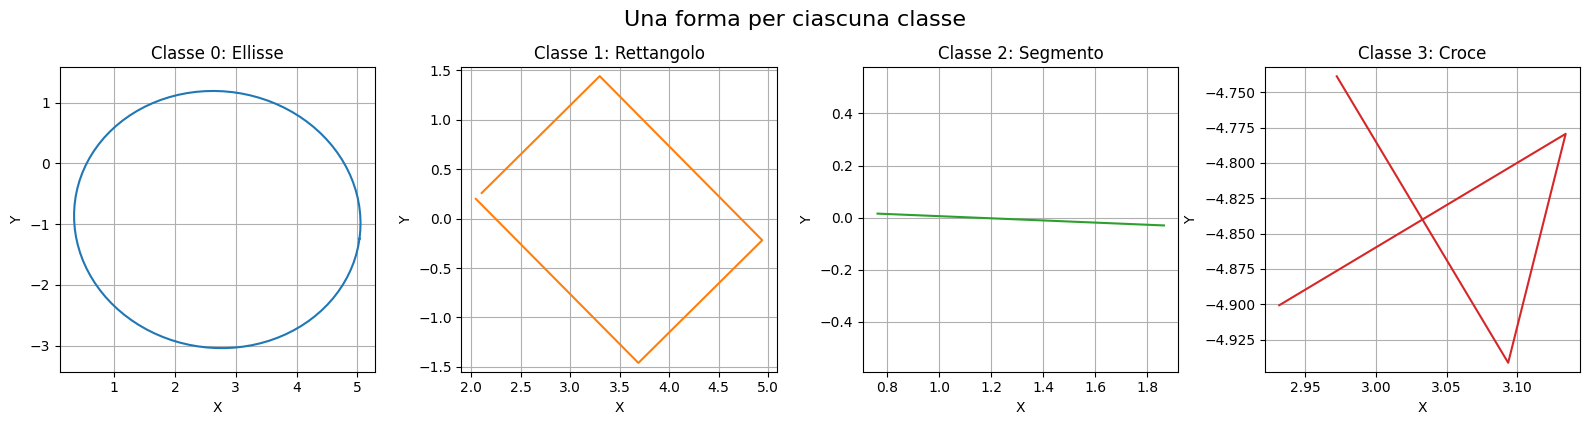

In [66]:
plot_shape(X, y, labels)

## Feature Selection

**Teoria**:

Le foreste casuali permettono di stimare l’importanza di ogni feature. L’importanza di una feature è calcolata come la riduzione totale (media su tutti gli alberi) dell’impurità (es. Gini) apportata dagli split su quella feature. Questo è uno strumento potente per la feature selection.

Algoritmo di Addestramento (CART)
L’algoritmo CART (Classification and Regression Trees) costruisce l’albero in modo greedy e ricorsivo.
1. Ad ogni nodo, cerca la migliore coppia (feature, soglia) che produca lo split più "puro".
2. La purezza dello split è misurata da una funzione di costo. Le più comuni sono:
- Impurità di Gini: Misura la probabilità di classificare erroneamente un campione se fosse etichettato casualmente secondo la distribuzione delle
classi nel nodo. Un nodo puro ha Gini=0.
- Entropia: Misura il disordine. L’algoritmo cerca di massimizzare l’Information Gain, ovvero la riduzione di entropia dopo lo split.
3. L’algoritmo si ripete sui nodi figli finché non si raggiunge una condizione di stop (es. ‘max depth‘, ‘min samples leaf‘).



Definiamo una nuova rappresentazione per ciascuna forma, nel seguente modo: invece di usare gli $n$ punti generati, introduciamo $12$ features, ovvero:
- Area
- Area convessa
- Rapporto tra le aree
- Perimetro
- Distanze tra punti estremi
- Aspect ratio ed eccentricità
- media, deviazione standard, massimo e minimo della distanza dal centroide
- distanza massima tra punti

Di queste $12$ feature, andiamo a selezionare le più rilevanti facendo **feature selection**.

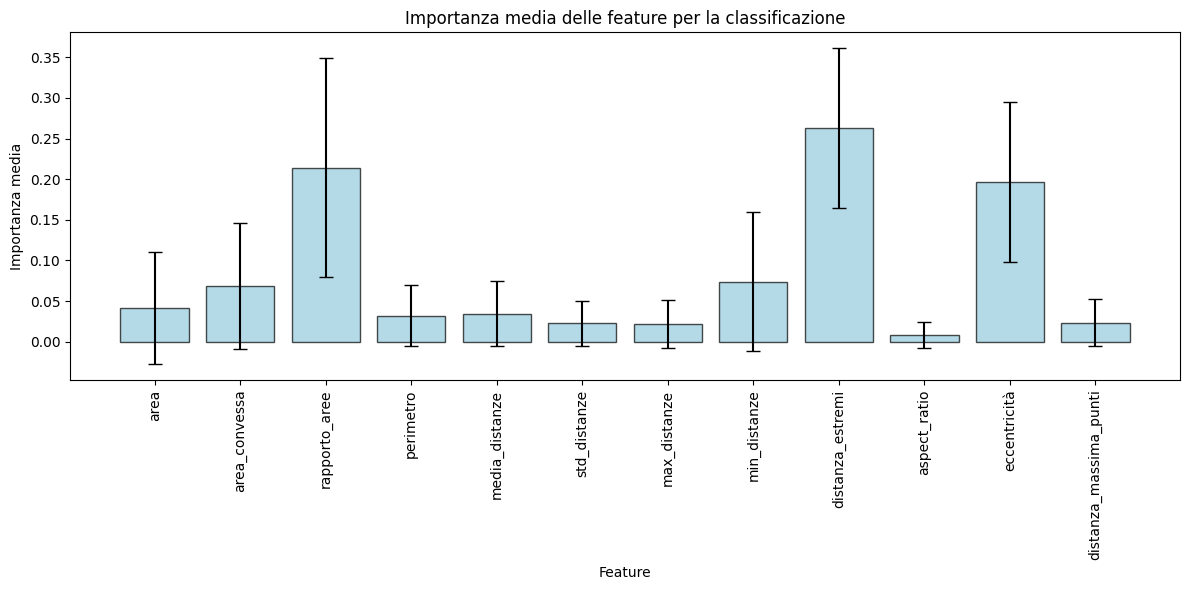

Importanza media delle feature:  
area: 0.0414 ± 0.0689
area_convessa: 0.0681 ± 0.0776
rapporto_aree: 0.2142 ± 0.1347
perimetro: 0.0321 ± 0.0376
media_distanze: 0.0345 ± 0.0401
std_distanze: 0.0224 ± 0.0272
max_distanze: 0.0222 ± 0.0295
min_distanze: 0.0736 ± 0.0854
distanza_estremi: 0.2630 ± 0.0982
aspect_ratio: 0.0079 ± 0.0160
eccentricità: 0.1969 ± 0.0986
distanza_massima_punti: 0.0236 ± 0.0290


In [67]:

X_selection = ottieni_features(X) # solo 12 features, senza punti e distanze dal centroide

forest = ExtraTreesClassifier(n_estimators=250, random_state=0) # aggiunge più randomizzazione nella scelta della soglia
forest.fit(X_selection, y)

ff = np.array([tree.feature_importances_ for tree in forest.estimators_])

n_punti = X.shape[1]

feature_names = ['area', 'area_convessa', 'rapporto_aree', 'perimetro','media_distanze', 'std_distanze', 'max_distanze', 'min_distanze','distanza_estremi', 'aspect_ratio', 'eccentricità', 'distanza_massima_punti']

importanze_medie = ff.mean(axis=0)
importanze_std = ff.std(axis=0)

df_plot = pd.DataFrame({
    "feature": feature_names,
    "importanza": importanze_medie,
    "errore": importanze_std
})

plt.figure(figsize=(12, 6))
sns.barplot(data=df_plot, x="feature", y="importanza", errorbar=None, alpha=0.7, color='skyblue', edgecolor='black')

plt.errorbar(x=range(len(feature_names)), y=importanze_medie, yerr=importanze_std, fmt='none', c='black', capsize=5)

plt.xticks(rotation=90)
plt.title('Importanza media delle feature per la classificazione')
plt.ylabel('Importanza media')
plt.xlabel('Feature')
plt.tight_layout()
plt.show()

print("Importanza media delle feature:  ")
for feature, importanza, errore in zip(feature_names, importanze_medie, importanze_std):
    print(f"{feature}: {importanza:.4f} ± {errore:.4f}")


misurare e visualizzare l'importanza relativa di ciascuna delle 12 feature ingegnerizzate ci permette di rispondere a domande cruciali come:

- "Quali proprietà geometriche sono più utili per distinguere una croce da un rettangolo?"
- "L'eccentricità è più o meno importante del rapporto tra le aree?"
- "Le feature che ho creato sono davvero informative?"

I risultati di questa analisi possono essere usati per validare il processo di feature engineering e per semplificare il modello (usando solo le feature più importanti).

Adesso, una volta calcolata l'importanza di ciascuna feature, prendiamo quelle che ci offrono maggiori informazioni per l'addestramento. Come facciamo a capire quante feature prendere? Andiamo ad addestrare $d$ classificatori, dove $d$ è il numero di feature, e per ciascun classificatore ci calcoliamo l'acuratezza delle predizioni, e guardando poi il grafico, scegliamo il numero di feature da utilizzare.

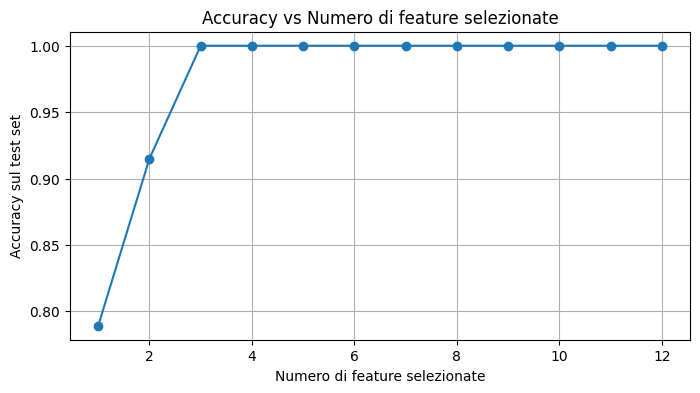

Accuratezza con tutte le feature: 1.0


In [68]:
idx_sorted = np.argsort(importanze_medie)[::-1]  # indici delle feature ordinate per importanza decrescente

accuracies = []
feature_range = range(1, len(feature_names) + 1)
for k in feature_range:
    X_f_k = X_selection[:, idx_sorted[:k]]
    X_train_k, X_test_k, y_train_k, y_test_k = train_test_split(X_f_k, y, test_size=0.3, random_state=42, stratify=y)
    clf_k = RandomForestClassifier(random_state=42)
    clf_k.fit(X_train_k, y_train_k)
    y_pred_k = clf_k.predict(X_test_k)
    acc_k = accuracy_score(y_test_k, y_pred_k)
    accuracies.append(acc_k)

plt.figure(figsize=(8, 4))
plt.plot(feature_range, accuracies, marker='o')
plt.xlabel('Numero di feature selezionate')
plt.ylabel('Accuracy sul test set')
plt.title('Accuracy vs Numero di feature selezionate')
plt.grid(True)
plt.show()

print("Accuratezza con tutte le feature:", accuracies[-1])

Questo codice non vuole solo sapere quali feature sono importanti, ma quante ne servono per raggiungere una performance ottimale. Risponde a domande come:

- "Posso ottenere un'accuratezza quasi perfetta usando solo le prime 5 feature più importanti?"
- "Aggiungere le feature meno importanti migliora, peggiora o lascia invariata la performance del modello?"

In [69]:
def seleziona_feature_custom(X, idx_sorted, k):
    return X[:, idx_sorted[:k]]

mettiamo in pratica le conclusioni tratte dall'analisi di importanza e di selezione delle feature. Invece di usare tutte le 12 feature, si decide di costruirne una versione più semplice e potenzialmente più efficiente, usando solo un sottoinsieme delle feature più potenti.

Lo scopo è dimostrare che è possibile ottenere un'accuratezza eccellente (o addirittura migliore, se le feature scartate introducevano rumore) con un modello meno complesso.

In [70]:
top_k = 7
feature_selezionate = [feature_names[i] for i in idx_sorted[:top_k]]
print("Feature più importanti:", feature_selezionate)

X_f_selected = seleziona_feature_custom(X_selection, idx_sorted, top_k)

X_train_sel, X_test_sel, y_train_sel, y_test_sel = train_test_split(X_f_selected, y, test_size=0.3, random_state=42, stratify=y)

clf_sel = RandomForestClassifier(random_state=42)
clf_sel.fit(X_train_sel, y_train_sel)
y_pred_sel = clf_sel.predict(X_test_sel)
acc_sel = accuracy_score(y_test_sel, y_pred_sel)
print(f"Accuracy sul test set usando solo le {top_k} feature più importanti: {acc_sel:.4f}")

Feature più importanti: ['distanza_estremi', 'rapporto_aree', 'eccentricità', 'min_distanze', 'area_convessa', 'area', 'media_distanze']
Accuracy sul test set usando solo le 7 feature più importanti: 1.0000


## Feature Extraction (PCA)

**Teoria**:

La Principal Component Analysis (PCA) è la tecnica di feature extraction più comune. Il suo obiettivo è ridurre il numero di feature proiettando i dati in uno spazio a dimensionalità
inferiore, cercando di preservare la massima varianza possibile.

**Come Funziona**:

1. Standardizzare i dati.
2. Calcolare la matrice di covarianza S del dataset.
3. Calcolare gli autovettori e gli autovalori della matrice di covarianza.
4. Gli autovettori, ordinati per autovalore decrescente, rappresentano le componenti principali. Ogni autovettore è una direzione nel nuovo spazio delle feature, e il corrispondente
autovalore indica la quantità di varianza spiegata da quella direzione.
5. Per ridurre la dimensionalità da d a d′ , si scelgono i primi d′ autovettori (quelli con gli autovalori più grandi) e si proiettano i dati originali su di essi.

**Scelta di d’**: Si può scegliere il numero di componenti d′ in modo da preservare una certa soglia di varianza cumulata (es. il 95%).

**Obiettivo Generale**

L'obiettivo di questo codice è duplice:

Combinare tutte le informazioni disponibili: Unire le feature ingegnerizzate (come area, perimetro), le distanze dal centroide e le coordinate grezze dei punti in un unico, grande vettore di feature.

Ridurre la dimensionalità: Utilizzare la PCA per "comprimere" questo enorme vettore di feature in un numero molto più piccolo (30) di nuove feature, chiamate componenti principali, preservando al contempo la maggior quantità possibile di informazione (varianza) presente nei dati originali.

Questa è una strategia molto comune quando si ha un numero elevato di feature, specialmente se sono correlate tra loro.



In [71]:
X_extraction = ottieni_features(X, distanze=True, points=True)

print("Shape di X_extraction:", X_extraction.shape)
print("Shape di y:", y.shape)

n_features = 30
pca = PCA(n_components=n_features, svd_solver="randomized", whiten=True).fit(X_extraction)
X_train, X_test, y_train_pca, y_test_pca = train_test_split(X_extraction, y, test_size=0.3, random_state=42, stratify=y)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

print("Shape pca_train:", X_train_pca.shape)
print("Shape pca_test:", X_test_pca.shape)
print("Shape y_train:", y_train_pca.shape)
print("Shape y_test:", y_test_pca.shape)

Shape di X_extraction: (4000, 312)
Shape di y: (4000,)
Shape pca_train: (2800, 30)
Shape pca_test: (1200, 30)
Shape y_train: (2800,)
Shape y_test: (1200,)


**Creazione di un Set di Feature Esteso:**

La funzione ottieni_features viene chiamata con i parametri distanze=True e points=True.

Questo crea una matrice X_extraction molto "larga", che per ogni forma contiene:

- Le 200 coordinate grezze dei punti.
- Le 100 distanze di ogni punto dal centroide.
- Le 12 feature geometriche ingegnerizzate.

Il risultato è un vettore di 312 feature totali per ogni campione.

**Addestramento del Modello PCA:**

Viene creato un oggetto PCA di Scikit-learn. I parametri sono importanti:

- n_components=30: Specifica che vogliamo ridurre le 312 feature originali a sole 30 componenti principali.

- svd_solver="randomized": È un'impostazione di ottimizzazione che rende il calcolo della PCA molto più veloce su dataset con molte feature, trovando in modo approssimato le componenti principali più importanti.

- whiten=True: Applica una standardizzazione alle componenti principali risultanti, in modo che abbiano tutte media 0 e varianza 1. Questo può essere molto utile per gli algoritmi di classificazione che seguiranno.

Il modello PCA viene addestrato sull'intero dataset X_extraction (.fit(X_extraction)) per imparare quali sono le direzioni di massima varianza dei dati.
Trasformazione dei Dati:

Per prima cosa, il dataset ad alta dimensionalità (X_extraction) viene diviso in set di addestramento e di test.

Successivamente, il modello PCA addestrato viene usato per trasformare sia il training set (pca.transform(X_train)) sia il test set (pca.transform(X_test)). È cruciale usare .transform su entrambi senza ri-addestrare il modello, per garantire che la stessa trasformazione sia applicata a tutti i dati.

In [72]:
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_pca, y_train_pca)
y_pred = clf.predict(X_train_pca)
acc = accuracy_score(y_train_pca, y_pred)
print(f"Accuracy sul training set: {acc:.4f}")
y_pred = clf.predict(X_test_pca)
acc = accuracy_score(y_test_pca, y_pred)
print(f"Accuracy sul test set: {acc:.4f}")

Accuracy sul training set: 1.0000
Accuracy sul test set: 1.0000


**Obiettivo Generale**

Lo scopo di questo codice è semplice e diretto:

- Addestrare un modello di classificazione (RandomForestClassifier) utilizzando le 30 componenti principali generate nel passaggio precedente.
- Valutare l'efficacia di questa rappresentazione dei dati misurando l'accuratezza del modello sia sul set di addestramento che, soprattutto, sul set di test.
Il risultato di questo blocco, in particolare l'accuracy sul test set, serve come metrica finale per giudicare l'intero approccio basato sulla PCA e per confrontarlo con l'approccio basato sulla selezione manuale delle feature.

# Model Selection

In questa fase andremo a testare vari modelli di classificatori, cercando il migliore. Andremo ad usare i seguenti modelli: `RandomForest`, `LinearRegressione` e `SVM`. Andremo a testare ciascun modello sia sul dataset ottenuto mediante feature selection che su quello ottenuto mediante PCA.

Effettuo Model Selection usando come datasets di train quelli ottenuti nella fase di feature selection e nella fase di feature extraction. Una volta finito l'addestramento, verifico il modello sul test set appropriato. Dovendo fare model selection su due dataset diversi, cerco il migliore estimatore per quanto riguarda feature selection, ed il miglior estimatore per quanto riguarda PCA.

In [73]:
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='macro', zero_division=0),
    'recall': make_scorer(recall_score, average='macro', zero_division=0),
    'f-score': make_scorer(f1_score, average='macro', zero_division=0)
}

# Qui posso facilmente aggiungere ulteriori dataset, per esempio con tutti i punti e le distanze

X_train_sets = {"Feature Selection": X_train_sel, "PCA": X_train_pca}
y_train_sets = {"Feature Selection": y_train_sel, "PCA": y_train_pca}

X_test_sets = {"Feature Selection": X_test_sel, "PCA": X_test_pca}
y_test_sets = {"Feature Selection": y_test_sel, "PCA": y_test_pca}

## 1. RandomForest

**Teoria**:

Una Random Forest costruisce un gran numero di alberi di decisione su sottoinsiemi diversi dei dati e poi aggrega le loro predizioni (con un voto di maggioranza per la classificazione).

**Come Funziona**:

La "casualità" è introdotta in due modi:

- **Bagging (Bootstrap Aggregating)**: Ogni albero è addestrato su un campione bootstrap del training set (un campione della stessa dimensione, estratto con reinserimento).
- **Subspace Sampling**: Ad ogni split di ogni albero, viene considerato solo un sottoinsieme casuale delle feature totali.

Questi due meccanismi producono alberi molto diversi tra loro (decorrelati). La loro aggregazione riduce drasticamente la varianza e l’overfitting, portando a modelli molto robusti e
performanti.


Qui si implementa un processo di ottimizzazione degli iperparametri e valutazione di modelli di classificazione basati su RandomForestClassifier. L'obiettivo è trovare la migliore combinazione di iperparametri per un modello Random Forest, addestrarlo su diversi set di dati e infine valutarne le performance su dati di test mai visti prima.

**Il processo si articola in due fasi principali:**

- Ricerca e Addestramento: Utilizza GridSearchCV per testare sistematicamente diverse combinazioni di iperparametri su più set di dati di addestramento (X_train_sets).

- Valutazione Finale: Usa i modelli migliori trovati nella fase precedente per fare predizioni sui corrispondenti set di test (X_test_sets) e ne misura le performance.

La prima sezione definisce **param_grid**, un dizionario che contiene gli iperparametri da testare per il RandomForestClassifier. Gli iperparametri sono impostazioni del modello che non vengono apprese dai dati, ma che devono essere definite prima dell'addestramento.

**"n_estimators": Il numero di alberi decisionali da costruire nella foresta.** Un numero maggiore di alberi tende a migliorare le performance e a rendere le previsioni più stabili, ma aumenta il costo computazionale. Verranno testati modelli con 50, 100 e 200 alberi.

**"max_depth": La profondità massima di ogni albero decisionale.**

- None: Gli alberi crescono finché tutte le foglie sono "pure" (contengono campioni di una sola classe) o finché non raggiungono il limite di min_samples_split. Alberi molto profondi possono causare overfitting.

- 10, 20: Limita la crescita dell'albero, aiutando a prevenire l'overfitting.

**"max_features": Il numero di feature da considerare quando si cerca la migliore suddivisione (split) in un nodo.**

- "sqrt": Utilizza la radice quadrata del numero totale di feature.

- "log2": Utilizza il logaritmo in base 2 del numero totale di feature.
Limitarne il numero aiuta a ridurre la varianza del modello e a diversificare gli alberi.

**"min_samples_split": Il numero minimo di campioni richiesti per poter suddividere un nodo interno.** Valori più alti prevengono la creazione di split basati su pochi campioni, rendendo il modello più generale e meno incline all'overfitting.

eseguirà 36 (combinazioni) x times5 = 180 addestramenti per ogni dataset.

In [74]:
param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [None, 10, 20],
    "max_features": ["sqrt", "log2"],
    "min_samples_split": [2, 5],
}

best_models_rf = {}

for name, X_train_set in X_train_sets.items():
    y_train_set = y_train_sets[name]

    rf = RandomForestClassifier(random_state=42)
    grid = GridSearchCV(
        rf, param_grid, cv=5, scoring=scoring, refit="accuracy", n_jobs=-1
    )
    grid.fit(X_train_set, y_train_set)

    print(f"\nRisultati per: {name}")
    for metric in scoring.keys():
        mean = grid.cv_results_[f"mean_test_{metric}"][grid.best_index_]
        print(f"{metric.capitalize()}: {mean:.4f}")
    print("Best params:", grid.best_params_)

    best_models_rf[name] = grid.best_estimator_

for name in best_models_rf:
    y_test_set = y_test_sets[name]
    print(f"\nTest set performance for: {name}")
    y_pred = best_models_rf[name].predict(X_test_sets[name])
    print(f"Accuracy: {accuracy_score(y_test_set, y_pred):.4f}")
    print(classification_report(y_test_set, y_pred, zero_division=0))
        
# Modelli migliori: best_models_rf


Risultati per: Feature Selection
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F-score: 1.0000
Best params: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 50}

Risultati per: PCA
Accuracy: 0.9993
Precision: 0.9993
Recall: 0.9993
F-score: 0.9993
Best params: {'max_depth': None, 'max_features': 'log2', 'min_samples_split': 2, 'n_estimators': 50}

Test set performance for: Feature Selection
Accuracy: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       300
           1       1.00      1.00      1.00       300
           2       1.00      1.00      1.00       300
           3       1.00      1.00      1.00       300

    accuracy                           1.00      1200
   macro avg       1.00      1.00      1.00      1200
weighted avg       1.00      1.00      1.00      1200


Test set performance for: PCA
Accuracy: 1.0000
              precision    recall  f1-score   support

           0

Nella seconda parte, il codice itera su diversi set di dati di addestramento e per ognuno esegue la ricerca della configurazione migliore.

**best_models_rf = {}:** Viene creato un dizionario vuoto che servirà a memorizzare il miglior modello addestrato per ciascun set di dati.

**for name, X_train_set in X_train_sets.items()::** Inizia un ciclo. Si presume che X_train_sets sia un dizionario dove le chiavi (name) sono i nomi dei dataset e i valori (X_train_set) sono i dati di training (le feature).

**rf = RandomForestClassifier(random_state=42):** Viene creata un'istanza del classificatore. random_state=42 è fondamentale per la riproducibilità, garantendo che i risultati siano identici ogni volta che il codice viene eseguito.

**grid = GridSearchCV(...):** Questo è il cuore del processo. Viene creato un oggetto GridSearchCV con i seguenti parametri:

- rf: Il modello base da ottimizzare.

- param_grid: La griglia di iperparametri definita prima.

- cv=5: Specifica l'uso della Cross-Validation a 5 fold. Il training set viene diviso in 5 parti. Per ogni combinazione di iperparametri, il modello viene addestrato 5 volte, usando ogni volta una parte diversa come set di validazione e le restanti 4 come training. Questo fornisce una stima più robusta delle performance.

- scoring=scoring: Indica le metriche da utilizzare per valutare i modelli durante la cross-validation (es. accuracy, F1-score, precision). La variabile scoring non è definita nello snippet, ma è probabilmente un dizionario di metriche.

- refit="accuracy": Una volta trovata la migliore combinazione di iperparametri (quella che massimizza la metrica 'accuracy' durante la cross-validation), GridSearchCV ri-addestra automaticamente un nuovo modello sull'intero set di training (X_train_set) usando questi iperparametri ottimali. Questo modello finale è accessibile tramite grid.best_estimator_.

- n_jobs=-1: Istruisce GridSearchCV a utilizzare tutti i core della CPU disponibili per eseguire i calcoli in parallelo, accelerando notevolmente il processo.

- grid.fit(X_train_set, y_train_set): Avvia il processo di ricerca. GridSearchCV 

### Matrici di Confusione

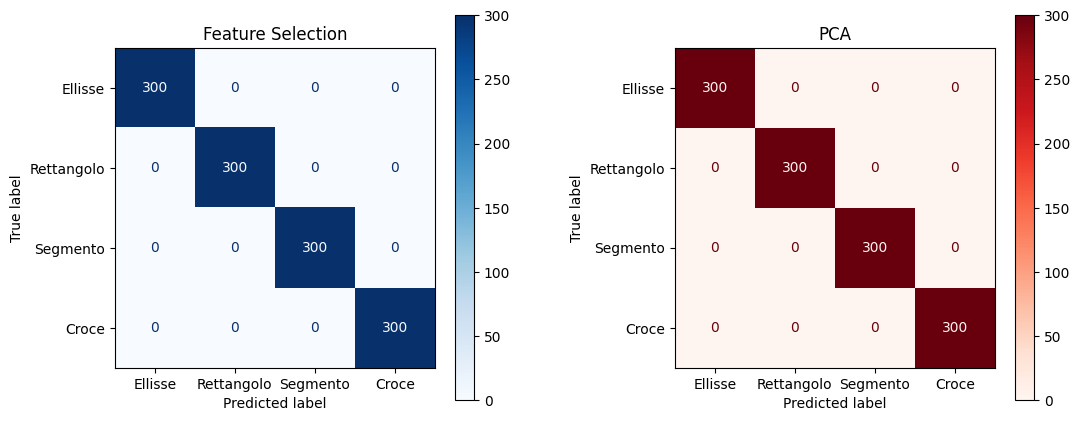

In [75]:
fig, axes = plt.subplots(1, len(best_models_rf), figsize=(12, 5))

# Plot matrice di confusione per Feature Selection
y_test_set_fs = y_test_sets["Feature Selection"]
y_pred_fs = best_models_rf["Feature Selection"].predict(X_test_sets["Feature Selection"])
ConfusionMatrixDisplay.from_predictions(
    y_test_set_fs, y_pred_fs,
    display_labels=[label.capitalize() for label in labels],
    cmap="Blues",
    ax=axes[0]
)
axes[0].set_title("Feature Selection")

# Plot matrice di confusione per PCA
y_test_set_pca = y_test_sets["PCA"]
y_pred_pca = best_models_rf["PCA"].predict(X_test_sets["PCA"])
ConfusionMatrixDisplay.from_predictions(
    y_test_set_pca, y_pred_pca,
    display_labels=[label.capitalize() for label in labels],
    cmap="Reds",
    ax=axes[1]
)
axes[1].set_title("PCA")

plt.subplots_adjust(wspace=0.4, left=0.1, right=0.9)
plt.show()

## 2. Logistic Regression

La Regressione Logistica è un algoritmo di classificazione che, nonostante il nome, non predice un valore numerico ma la probabilità che un dato appartenga a una specifica classe (es. Sì/No, Spam/Non Spam). Utilizza una funzione matematica (la sigmoide) per trasformare un input lineare in un valore compreso tra 0 e 1, interpretato appunto come probabilità.

A differenza del Percettrone e di ADALINE, che producono una classificazione netta (Sì/No), la Regressione Logistica fornisce un output probabilistico molto più informativo (es. "c'è il 75% di probabilità che sia 'Sì'"). Questo la rende più flessibile e permette un addestramento più stabile e affidabile.

Lo scopo di questo script è trovare il miglior modello di Regressione Logistica per diversi set di dati, ottimizzandone gli iperparametri. A differenza delle RandomForest, il modello di classificazione è inserito all'interno di una Pipeline che include anche una fase di pre-processing dei dati (StandardScaler - Standardizzazione).

**Il processo, anche qui, si articola in due fasi principali:**

- Ricerca e Addestramento tramite Pipeline: Utilizza GridSearchCV per testare diverse combinazioni di iperparametri per il modello LogisticRegression all'interno di una pipeline, che gestisce la standardizzazione dei dati e la classificazione.

- Valutazione Finale: Usa le pipeline migliori trovate nella fase precedente per fare predizioni sui dati di test e misurarne le performance.

**param_grid** definisce gli iperparametri da testare. La sintassi qui è specifica per l'uso con una Pipeline:

Sintassi nomepasso__parametro: La stringa 'logisticregression__C' indica a GridSearchCV di applicare l'iperparametro C al passo della pipeline chiamato logisticregression. I nomi dei passi in una make_pipeline sono assegnati automaticamente in minuscolo dal nome della classe (es. LogisticRegression diventa logisticregression).

**'logisticregression__C':** Il parametro C è l'inverso della forza di regolarizzazione.

- Valori bassi (es. 0.01) indicano una regolarizzazione forte (il modello è più semplice e meno propenso all'overfitting).

- Valori alti (es. 100) indicano una regolarizzazione debole (il modello può adattarsi più strettamente ai dati di training).

**'logisticregression__penalty':** Specifica la norma usata per la penalizzazione. 'L2' (nota come **Ridge**) è la forma di regolarizzazione più comune e tende a ridurre il valore di tutti i coefficienti del modello senza portarli esattamente a zero.

**'logisticregression__solver':** L'algoritmo da usare per l'ottimizzazione. 'lbfgs' è un ottimo solutore di default che funziona bene per problemi su piccola scala e gestisce la penalità l2.

**'logisticregression__max_iter':** Il numero massimo di iterazioni che il solutore può eseguire per convergere a una soluzione. Aumentare questo valore può essere necessario se il modello non riesce a convergere, specialmente con dati complessi.

In questo caso, il numero totale di combinazioni da testare è 5 --> 5(#parametri C) x 3(Max iter) = 15 Iterazioni

In [76]:
param_grid = {
    'logisticregression__C': [0.01, 0.1, 1, 10, 100],  
    'logisticregression__penalty': ['l2'],             
    'logisticregression__solver': ['lbfgs'],           
    'logisticregression__max_iter': [1000, 2000, 5000]             
}

best_models_lrg = {}

for name, X_train_set in X_train_sets.items():
    y_train_set = y_train_sets[name]
    
    pipeline = make_pipeline(
        StandardScaler(),
        LogisticRegression(random_state=42)
    )

    grid = GridSearchCV(
        pipeline,
        param_grid,
        cv=5,
        scoring=scoring,
        refit='accuracy',
        n_jobs=-1
    )
    grid.fit(X_train_set, y_train_set)

    print(f"\nRisultati per: {name}")
    for metric in scoring.keys():
        mean = grid.cv_results_[f"mean_test_{metric}"][grid.best_index_]
        print(f"{metric.capitalize()}: {mean:.4f}")
    print("Best params:", grid.best_params_)
    
    best_models_lrg[name] = grid.best_estimator_

for name in best_models_lrg:
    y_test_set = y_test_sets[name]
    print(f"\nTest set performance for: {name}")
    y_pred = best_models_lrg[name].predict(X_test_sets[name])
    print(f"Accuracy: {accuracy_score(y_test_set, y_pred):.4f}")
    print(classification_report(y_test_set, y_pred, zero_division=0))

# Modelli migliori: best_models_lrg


Risultati per: Feature Selection
Accuracy: 0.9986
Precision: 0.9986
Recall: 0.9986
F-score: 0.9986
Best params: {'logisticregression__C': 100, 'logisticregression__max_iter': 1000, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'lbfgs'}

Risultati per: PCA
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F-score: 1.0000
Best params: {'logisticregression__C': 0.01, 'logisticregression__max_iter': 1000, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'lbfgs'}

Test set performance for: Feature Selection
Accuracy: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       300
           1       1.00      1.00      1.00       300
           2       1.00      1.00      1.00       300
           3       1.00      1.00      1.00       300

    accuracy                           1.00      1200
   macro avg       1.00      1.00      1.00      1200
weighted avg       1.00      1.00      1.00      1200



- **best_models_lrg = {}:** Inizializza un dizionario vuoto per salvare le pipeline migliori.

- **for name, X_train_set...:** Inizia il ciclo sui diversi set di dati, come nell'esempio precedente.

- **pipeline = make_pipeline(...):** Questa è la parte più importante. Viene creata una pipeline, ovvero una sequenza di passaggi di trasformazione e stima dei dati.

- **StandardScaler():** Questo è il primo passo. Standardizza le feature rimuovendo la media e scalando i dati in modo che abbiano varianza unitaria. Questo passaggio è fondamentale per modelli sensibili alla scala delle feature, come la Regressione Logistica, perché garantisce che nessuna feature domini le altre solo perché ha valori numerici più grandi.

La **Standardizzazione** è un passo di pre-processing che trasforma le feature in modo che abbiano media nulla e deviazione standard unitaria:

$$x'_j = \frac{x_j - u_j}{o_j}$$

Perché è fondamentale? Algoritmi che si basano su distanze (KNN, SVM) o sulla discesa del gradiente (SGD, Reti Neurali) sono sensibili alla scala delle feature. Se una feature ha un
range di valori molto più grande di un’altra, dominerà il calcolo della distanza o il gradiente della funzione di costo. **La standardizzazione assicura che tutte le feature contribuiscano equamente, rendendo la convergenza più rapida e stabile.**

- **LogisticRegression(random_state=42):** Questo è il secondo e ultimo passo, il nostro modello di classificazione.

Il Vantaggio della Pipeline: Usare una pipeline con GridSearchCV è una best practice perché previene il data leakage. Durante la cross-validation (cv=5), per ogni "fold", lo StandardScaler viene addestrato (fit) solo sulla porzione di training di quel fold e poi usato per trasformare (transform) sia la porzione di training che quella di validazione. Questo simula correttamente come il modello si comporterebbe con dati nuovi.

- **grid = GridSearchCV(pipeline, ...):** L'oggetto GridSearchCV viene creato passando l'intera pipeline come stimatore da ottimizzare.

- **grid.fit(...):** Avvia il processo di ricerca. Per ogni combinazione di iperparametri e per ogni fold di cross-validation, l'intero pipeline viene eseguito: i dati di training vengono scalati e poi usati per addestrare la Regressione Logistica.

- **best_models_lrg[name] = grid.best_estimator_:** Alla fine della ricerca, grid.best_estimator_ non è solo un modello LogisticRegression, ma l'intera pipeline addestrata con i migliori iperparametri e con lo StandardScaler già fittato sull'intero set di training.

### Matrici di Confusione

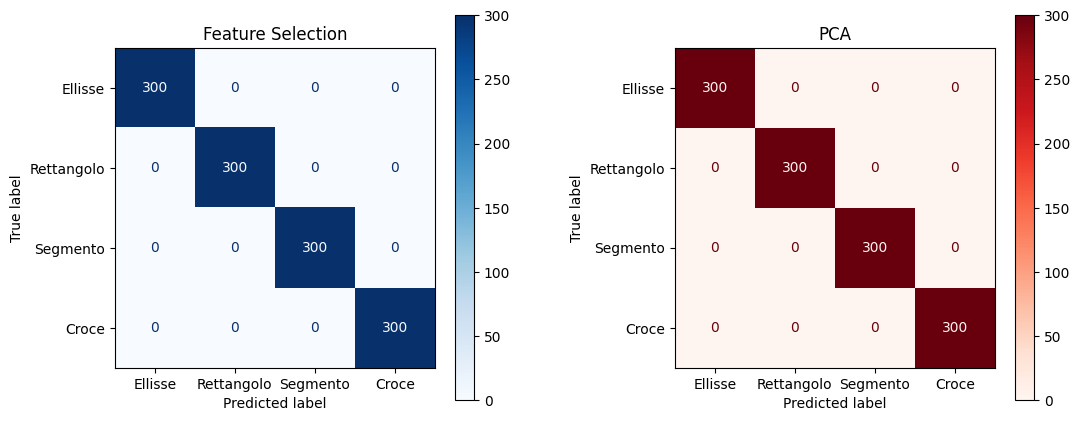

In [77]:
fig, axes = plt.subplots(1, len(best_models_lrg), figsize=(12, 5))

# Plot matrice di confusione per Feature Selection
y_test_set_fs = y_test_sets["Feature Selection"]
y_pred_fs = best_models_lrg["Feature Selection"].predict(X_test_sets["Feature Selection"])
ConfusionMatrixDisplay.from_predictions(
    y_test_set_fs, y_pred_fs,
    display_labels=[label.capitalize() for label in labels],
    cmap="Blues",
    ax=axes[0]
)
axes[0].set_title("Feature Selection")

# Plot matrice di confusione per PCA
y_test_set_pca = y_test_sets["PCA"]
y_pred_pca = best_models_lrg["PCA"].predict(X_test_sets["PCA"])
ConfusionMatrixDisplay.from_predictions(
    y_test_set_pca, y_pred_pca,
    display_labels=[label.capitalize() for label in labels],
    cmap="Reds",
    ax=axes[1]
)
axes[1].set_title("PCA")

plt.subplots_adjust(wspace=0.4, left=0.1, right=0.9)
plt.show()

## 3. SVM

**Teoria**:

A differenza del Percettrone che si accontenta di un qualsiasi iperpiano separatore, l’SVM cerca quello ottimo: l’iperpiano che massimizza il margine, ovvero la distanza tra l’iperpiano stesso e i campioni più vicini di entrambe le classi. Questi campioni sono detti vettori di supporto.

**Hard Margin vs. Soft Margin**:

- Hard Margin: Richiede che i dati siano perfettamente separabili e non tollera alcun punto all’interno del margine. Molto sensibile agli outlier.

- Soft Margin: Permette violazioni del margine, introducendo un compromesso tra massimizzare il margine e minimizzare le violazioni. Questo compromesso è controllato dall’iperparametro di regolarizzazione C:
- C piccolo → Margine largo, più violazioni permesse (alta regolarizzazione, previene overfitting).
- C grande → Margine stretto, poche violazioni (bassa regolarizzazione, rischio di overfitting).

**Il Kernel Trick**:

Per gestire dati non linearmente separabili, le SVM usano il kernel trick. L’idea è di proiettare i dati in uno spazio a dimensionalità superiore dove diventano separabili, senza però calcolare mai esplicitamente questa trasformazione. Le funzioni kernel calcolano il prodotto scalare tra i punti come se fossero in questo nuovo spazio.

- Lineare: Nessuna trasformazione.

- Polinomiale (‘poly‘): Utile per confini decisionali curvi.

- Gaussiano RBF (‘rbf ‘): Il più potente e comune. Può creare confini molto complessi. È controllato dall’iperparametro ‘gamma‘.


Lo script ha l'obiettivo di trovare i migliori iperparametri per un modello di classificazione SVC, addestrarlo e valutarlo su più set di dati. Come per l'esempio della Regressione Logistica, il modello è inserito in una Pipeline che gestisce la standardizzazione dei dati, un passaggio cruciale per le performance degli SVM.

**Il processo è il seguente:**

- Ricerca e Addestramento: Utilizza GridSearchCV per testare diverse configurazioni del modello SVC (kernel, regolarizzazione, ecc.) all'interno di una pipeline di pre-processing e classificazione.

- Valutazione Finale: Impiega le pipeline ottimizzate per valutare le performance su dati di test mai visti.

- **param_grid** definisce gli iperparametri da testare per il modello SVC. La sintassi svc__parametro indica che i parametri appartengono al passo svc della pipeline.

- **'svc__kernel':** Questo è l'iperparametro più importante di un SVM, poiché definisce la forma del confine decisionale.

- **'linear':** Utilizza un iperpiano lineare per separare le classi. È veloce e adatto a problemi in cui i dati sono linearmente separabili.

- **'rbf' (Radial Basis Function):** È un kernel non lineare, molto potente e flessibile. Può creare confini decisionali complessi ed è una scelta di default molto comune quando la relazione tra i dati non è nota.

- **'svc__C':** Il parametro di regolarizzazione. Controlla il compromesso tra massimizzare il margine (la "strada" tra le classi) e minimizzare l'errore di classificazione sui dati di training.

- Valori bassi (es. 0.1) creano un margine più ampio ma potrebbero classificare erroneamente alcuni punti di training (maggiore regolarizzazione, modello più generale).

- Valori alti (es. 10) creano un margine più stretto, cercando di classificare correttamente più punti di training possibili, col rischio di overfitting.

**'svc__gamma':** Un parametro specifico per i kernel non lineari come 'rbf'. Definisce l'influenza di un singolo punto di training.

- Un gamma basso significa che un punto ha un'influenza ampia, portando a un confine decisionale più liscio.

- Un gamma alto significa che un punto ha un'influenza locale e ristretta, portando a un confine più complesso e "frastagliato", che può adattarsi eccessivamente al rumore nei dati.

'scale' e 'auto' sono strategie automatiche per impostare un valore di gamma ragionevole in base alle caratteristiche dei dati.

Il numero totale di combinazioni da testare è: 2 x times3 x times2 = 12.

In [78]:
param_grid = {
    'svc__kernel': ['linear', 'rbf'],
    'svc__C': [0.1, 1, 10],
    'svc__gamma': ['scale', 'auto']
}

best_models_svm = {}

for name, X_train_set in X_train_sets.items():
    y_train_set = y_train_sets[name]
    
    pipeline = make_pipeline(
        StandardScaler(),
        SVC(random_state=42)
    )
    
    grid = GridSearchCV(
        pipeline,
        param_grid,
        cv=5,
        scoring=scoring,
        refit='accuracy',
        n_jobs=1
    )
    
    grid.fit(X_train_set, y_train_set)
    
    print(f"\nRisultati per: {name}")
    for metric in scoring.keys():
        mean = grid.cv_results_[f"mean_test_{metric}"][grid.best_index_]
        print(f"{metric.capitalize()}: {mean:.4f}")
    print("Best params:", grid.best_params_)
    
    best_models_svm[name] = grid.best_estimator_

for name in best_models_svm:
    y_test_set = y_test_sets[name]
    print(f"\nTest set performance for: {name}")
    y_pred = best_models_svm[name].predict(X_test_sets[name])
    print(f"Accuracy: {accuracy_score(y_test_set, y_pred):.4f}")
    print(classification_report(y_test_set, y_pred, zero_division=0))


Risultati per: Feature Selection
Accuracy: 0.9957
Precision: 0.9958
Recall: 0.9957
F-score: 0.9957
Best params: {'svc__C': 10, 'svc__gamma': 'scale', 'svc__kernel': 'linear'}

Risultati per: PCA
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F-score: 1.0000
Best params: {'svc__C': 1, 'svc__gamma': 'scale', 'svc__kernel': 'linear'}

Test set performance for: Feature Selection
Accuracy: 0.9983
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       300
           1       0.99      1.00      1.00       300
           2       1.00      1.00      1.00       300
           3       1.00      1.00      1.00       300

    accuracy                           1.00      1200
   macro avg       1.00      1.00      1.00      1200
weighted avg       1.00      1.00      1.00      1200


Test set performance for: PCA
Accuracy: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       300
         

**best_models_svm = {}:** Inizializza un dizionario per salvare le pipeline ottimizzate per ogni dataset.

**pipeline = make_pipeline(StandardScaler(), SVC(...)):** Viene creata una pipeline.

**StandardScaler():** Questo passaggio è critico per gli SVM. Poiché i kernel (specialmente 'rbf') si basano su misure di distanza, avere feature su scale molto diverse può far sì che le feature con range più ampi dominino il calcolo, portando a performance scadenti. La standardizzazione assicura che tutte le feature contribuiscano in modo equo.

**SVC(random_state=42):** Il classificatore SVM.

**grid = GridSearchCV(..., n_jobs=1):** Viene impostata la ricerca a griglia. Una nota importante qui è n_jobs=1. A differenza degli esempi precedenti (n_jobs=-1), questo significa che la ricerca verrà eseguita utilizzando un solo core della CPU. L'addestramento degli SVM, specialmente con grandi dataset e kernel rbf, può essere computazionalmente intensivo. L'uso di un solo core renderà il processo più lento, ma potrebbe essere una scelta deliberata per limitare l'uso di CPU e memoria su una macchina con risorse limitate.

**grid.fit(...):** Avvia il processo di addestramento. Per ogni combinazione di iperparametri e per ogni fold della cross-validation, la pipeline esegue la standardizzazione e l'addestramento dell'SVC.

Stampa dei Risultati e Salvataggio: Come negli altri script, vengono stampate le performance medie di validazione e i parametri migliori. Infine, la pipeline ottimale e già addestrata (grid.best_estimator_) viene salvata nel dizionario best_models_svm.

### Matrici di Confusione

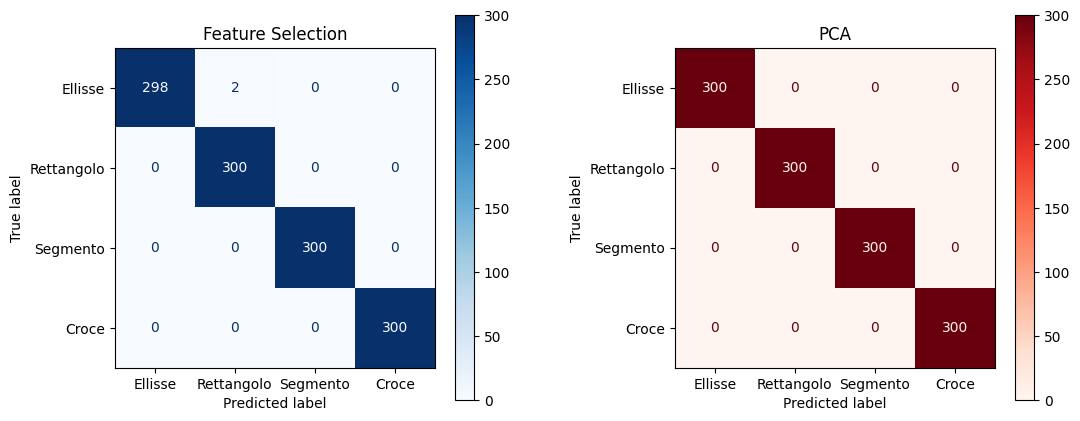

In [79]:
fig, axes = plt.subplots(1, len(best_models_svm), figsize=(12, 5))

# Plot matrice di confusione per Feature Selection
y_test_set_fs = y_test_sets["Feature Selection"]
y_pred_fs = best_models_svm["Feature Selection"].predict(X_test_sets["Feature Selection"])
ConfusionMatrixDisplay.from_predictions(
    y_test_set_fs, y_pred_fs,
    display_labels=[label.capitalize() for label in labels],
    cmap="Blues",
    ax=axes[0]
)
axes[0].set_title("Feature Selection")

# Plot matrice di confusione per PCA
y_test_set_pca = y_test_sets["PCA"]
y_pred_pca = best_models_svm["PCA"].predict(X_test_sets["PCA"])
ConfusionMatrixDisplay.from_predictions(
    y_test_set_pca, y_pred_pca,
    display_labels=[label.capitalize() for label in labels],
    cmap="Reds",
    ax=axes[1]
)
axes[1].set_title("PCA")

plt.subplots_adjust(wspace=0.4, left=0.1, right=0.9)
plt.show()

## Testi di Robustezza

In [80]:
punti_fisso = 100
forme_fisso = 1000
rumore_fisso = 0.0

# Configurazioni da testare
punti = [100, 150, 200]
forme = [1000, 1500, 2000]
rumore = [0.1, 0.2, 0.5, 0.8]

datasets_variati = {
    "punti": {(forme_fisso, p, rumore_fisso): genera_campioni(forme_fisso, p, rumore_fisso) for p in punti},
    "forme": {(f, punti_fisso, rumore_fisso): genera_campioni(f, punti_fisso, rumore_fisso) for f in forme},
    "rumore": {(forme_fisso, punti_fisso, r): genera_campioni(forme_fisso, punti_fisso, r) for r in rumore}
}

In [81]:
print("[INFO]: PUNTI      - ", datasets_variati["punti"].keys())
print("[INFO]: FORME    - ", datasets_variati["forme"].keys())
print("[INFO]: RUMORE - ", datasets_variati["rumore"].keys())

[INFO]: PUNTI      -  dict_keys([(1000, 100, 0.0), (1000, 150, 0.0), (1000, 200, 0.0)])
[INFO]: FORME    -  dict_keys([(1000, 100, 0.0), (1500, 100, 0.0), (2000, 100, 0.0)])
[INFO]: RUMORE -  dict_keys([(1000, 100, 0.1), (1000, 100, 0.2), (1000, 100, 0.5), (1000, 100, 0.8)])


In [82]:
def valuta_modello(modello, X, y_true, ndigits=4):
    y_pred = modello.predict(X)
    return {
        "accuracy": round(accuracy_score(y_true, y_pred), ndigits),
        "precision": round(
            precision_score(y_true, y_pred, average="macro", zero_division=0), ndigits
        ),
        "recall": round(recall_score(y_true, y_pred, average="macro", zero_division=0), ndigits),
        "f1": round(f1_score(y_true, y_pred, average="macro", zero_division=0), ndigits),
    }


def feature_selection_test(model, parametri, nome, X, y):
    X_sel = ottieni_features(X)
    X_sel = seleziona_feature_custom(X_sel, idx_sorted, top_k)

    X_train, X_test, y_train, y_test = train_test_split(
        X_sel, y, test_size=0.3, random_state=42, stratify=y
    )

    model.fit(X_train, y_train)

    risultati = valuta_modello(model, X_test, y_test)
    risultati["parametri"] = {
        "tipo": nome,
        "forme": parametri[0],
        "punti": parametri[1],
        "rumore": parametri[2],
    }

    return risultati


def pca_test(model, parametri, nome, n_components, X, y):
    X_pca = ottieni_features(X, distanze=True, points=True)

    X_train, X_test, y_train_pca, y_test_pca = train_test_split(
        X_pca, y, test_size=0.3, random_state=42, stratify=y
    )

    pca = PCA(n_components=n_components, svd_solver="randomized", whiten=True)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    model.fit(X_train_pca, y_train_pca)

    risultati = valuta_modello(model, X_test_pca, y_test_pca)
    risultati["parametri"] = {
        "tipo": nome,
        "forme": parametri[0],
        "punti": parametri[1],
        "rumore": parametri[2],
    }

    return risultati


def test_robustezza_random_forest():
    results_selection = {}
    results_pca = {}

    for nome, tipo_dataset in datasets_variati.items():
        for parametri, (X, y) in tipo_dataset.items():  # parametri = (forme, punti, rumore)
            # FEATURE SELECTION

            parametri_modello = best_models_rf["Feature Selection"].get_params()
            parametri_modello["n_jobs"] = -1  # uso tutti i core a disposizione
            new_model_selection = RandomForestClassifier(**parametri_modello)

            risultati_sel = feature_selection_test(new_model_selection, parametri, nome, X=X, y=y)

            results_selection.setdefault(nome, []).append(risultati_sel)

            # FEATURE EXTRACTION CON PCA

            parametri_modello = best_models_rf["PCA"].get_params()
            parametri_modello["n_jobs"] = -1  # uso tutti i core a disposizione
            new_model_pca = RandomForestClassifier(**parametri_modello)

            risultati_pca = pca_test(new_model_pca, parametri, nome, n_components=10, X=X, y=y)

            results_pca.setdefault(nome, []).append(risultati_pca)

    return results_selection, results_pca


def test_robustezza_logistic_regression():
    results_selection = {}
    results_pca = {}

    for nome, tipo_dataset in datasets_variati.items():
        for parametri, (X, y) in tipo_dataset.items():

            parametri_modello = {
                k.split("__")[1]: v
                for k, v in best_models_lrg["Feature Selection"].get_params().items()
                if k.startswith("logisticregression__")
            }
            parametri_modello["n_jobs"] = -1
            new_model_selection = make_pipeline(
                StandardScaler(), LogisticRegression(**parametri_modello)
            )

            risultati_sel = feature_selection_test(new_model_selection, parametri, nome, X=X, y=y)

            results_selection.setdefault(nome, []).append(risultati_sel)

            # FEATURE EXTRACTION CON PCA

            parametri_modello = {
                k.split("__")[1]: v
                for k, v in best_models_lrg["Feature Selection"].get_params().items()
                if k.startswith("logisticregression__")
            }
            parametri_modello["n_jobs"] = -1
            new_model_pca = make_pipeline(StandardScaler(), LogisticRegression(**parametri_modello))

            risultati_pca = pca_test(new_model_pca, parametri, nome, n_components=10, X=X, y=y)

            results_pca.setdefault(nome, []).append(risultati_pca)

    return results_selection, results_pca


def test_robustezza_svm():
    results_selection = {}
    results_pca = {}

    for nome, tipo_dataset in datasets_variati.items():
        for parametri, (X, y) in tipo_dataset.items():

            parametri_modello = {
                k.split("__")[1]: v
                for k, v in best_models_lrg["Feature Selection"].get_params().items()
                if k.startswith("svc__")
            }
            new_model_selection = make_pipeline(StandardScaler(), SVC(**parametri_modello))

            risultati_sel = feature_selection_test(new_model_selection, parametri, nome, X=X, y=y)

            results_selection.setdefault(nome, []).append(risultati_sel)

            # FEATURE EXTRACTION CON PCA

            parametri_modello = {
                k.split("__")[1]: v
                for k, v in best_models_lrg["Feature Selection"].get_params().items()
                if k.startswith("svc__")
            }
            new_model_pca = make_pipeline(StandardScaler(), SVC(**parametri_modello))

            risultati_pca = pca_test(new_model_pca, parametri, nome, n_components=10, X=X, y=y)

            results_pca.setdefault(nome, []).append(risultati_pca)

    return results_selection, results_pca


def print_risultati(results_sel, results_pca):
    print("[INFO]: Risultati modello feature selection:\n")

    for keys, values in results_sel.items():
        print("Tipo di dataset:", keys)
        for val in values:
            print(val["accuracy"], val["parametri"])

    print("\n[INFO]: Risultati modello PCA:\n")
    for keys, values in results_pca.items():
        print("Tipo di dataset:", keys)
        for val in values:
            print(val["accuracy"], val["parametri"])


def plot_test_results(variazione, results, title, ax=None):
    """
    Plotta l'andamento di più metriche (accuracy, precision, recall, f1)
    al variare di un parametro del dataset.

    Args:
        variazione (str): Nome del parametro variato ("punti", "forme", "rumore").
        results (dict): Dizionario dei risultati, con chiave uguale a variazione.
        titolo_modello (str): Titolo aggiuntivo per il grafico.
        ax (matplotlib.axes._subplots.AxesSubplot): Asse su cui disegnare il grafico (opzionale).
    """
    risultati = results[variazione]
    valori_x = [res["parametri"][variazione] for res in risultati]

    # Estrazione delle metriche
    metriche = {
        "Accuracy": [res["accuracy"] for res in risultati],
        "Precision": [res["precision"] for res in risultati],
    }

    if ax is None:
        fig, ax = plt.subplots()

    # Tracciamento di ciascuna metrica
    for nome_metrica, valori_y in metriche.items():
        ax.plot(valori_x, valori_y, marker="o", linestyle="-", label=nome_metrica)

    # Etichette asse X
    if variazione == "rumore":
        ax.set_xlabel("Livello di rumore")
    elif variazione == "punti":
        ax.set_xlabel("Numero di punti per forma")
    elif variazione == "forme":
        ax.set_xlabel("Numero di forme")
    else:
        ax.set_xlabel(variazione.capitalize())

    # Etichette e titolo
    ax.set_ylabel("Valore metrica")
    ax.set_title(f"Andamento metriche vs {variazione.capitalize()} ({title})")
    ax.grid(True)
    ax.legend()

def plot_figure(results, title):
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))

    for i, var in enumerate(["punti", "forme", "rumore"]):
        plot_test_results(var, results=results, ax=axs[i], title=title)

    plt.tight_layout()
    plt.show()

### Risultati

In [83]:
results_selection_rf, results_pca_rf = test_robustezza_random_forest()

In [84]:
print_risultati(results_sel=results_selection_rf, results_pca=results_pca_rf)

[INFO]: Risultati modello feature selection:

Tipo di dataset: punti
0.9992 {'tipo': 'punti', 'forme': 1000, 'punti': 100, 'rumore': 0.0}
1.0 {'tipo': 'punti', 'forme': 1000, 'punti': 150, 'rumore': 0.0}
1.0 {'tipo': 'punti', 'forme': 1000, 'punti': 200, 'rumore': 0.0}
Tipo di dataset: forme
1.0 {'tipo': 'forme', 'forme': 1000, 'punti': 100, 'rumore': 0.0}
1.0 {'tipo': 'forme', 'forme': 1500, 'punti': 100, 'rumore': 0.0}
1.0 {'tipo': 'forme', 'forme': 2000, 'punti': 100, 'rumore': 0.0}
Tipo di dataset: rumore
0.8925 {'tipo': 'rumore', 'forme': 1000, 'punti': 100, 'rumore': 0.1}
0.8783 {'tipo': 'rumore', 'forme': 1000, 'punti': 100, 'rumore': 0.2}
0.8175 {'tipo': 'rumore', 'forme': 1000, 'punti': 100, 'rumore': 0.5}
0.73 {'tipo': 'rumore', 'forme': 1000, 'punti': 100, 'rumore': 0.8}

[INFO]: Risultati modello PCA:

Tipo di dataset: punti
0.9542 {'tipo': 'punti', 'forme': 1000, 'punti': 100, 'rumore': 0.0}
0.9475 {'tipo': 'punti', 'forme': 1000, 'punti': 150, 'rumore': 0.0}
0.9517 {'tipo

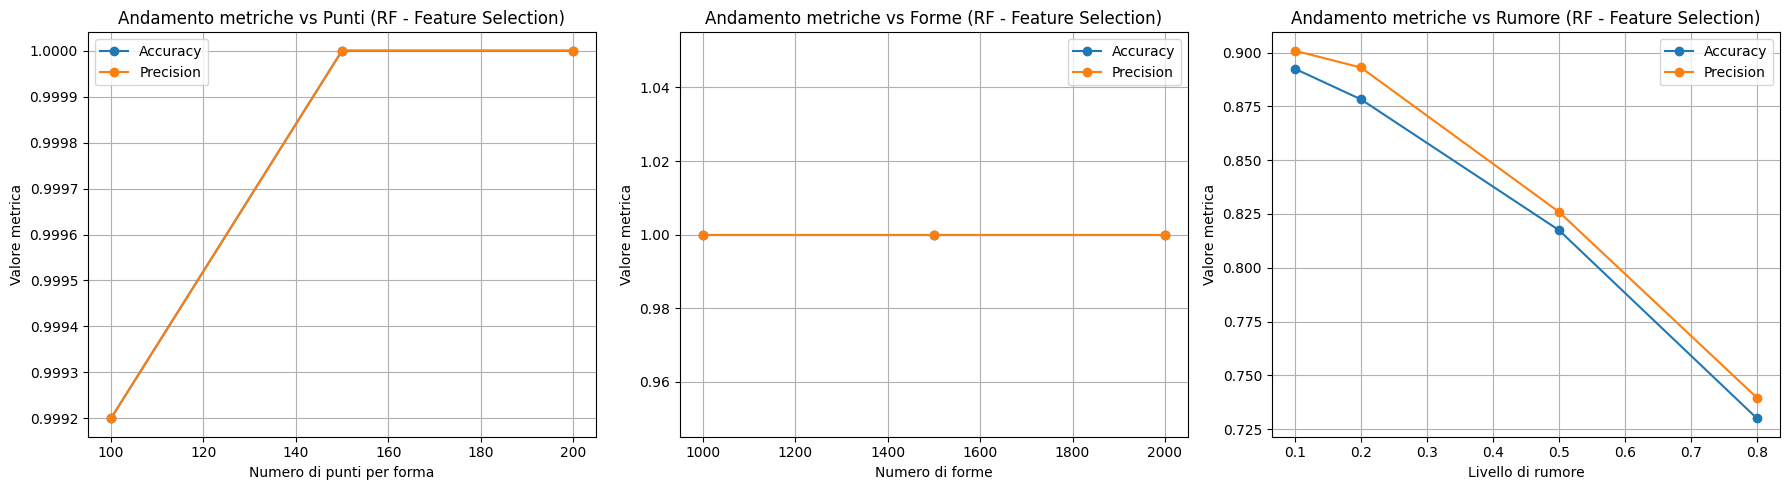

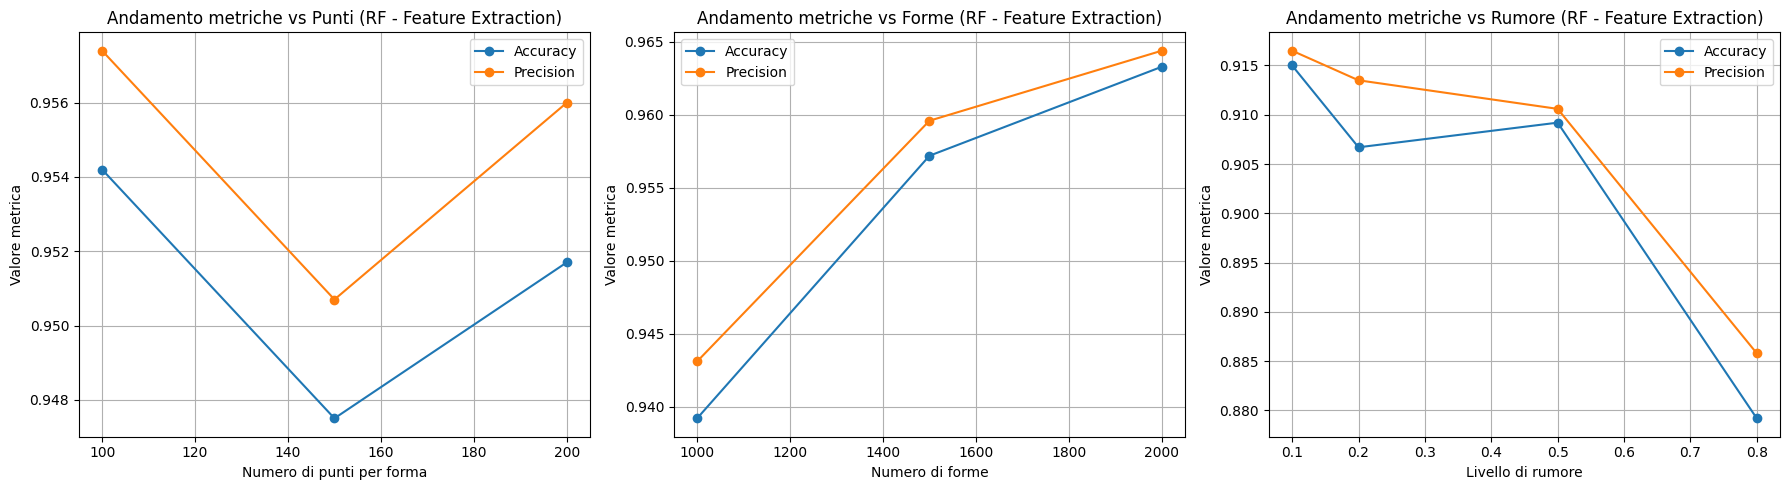

In [85]:
plot_figure(results=results_selection_rf, title="RF - Feature Selection")
plot_figure(results=results_pca_rf, title="RF - Feature Extraction")

In [86]:
results_selection_lrg, results_pca_lrg = test_robustezza_logistic_regression()

In [87]:
print_risultati(results_sel=results_selection_lrg, results_pca=results_pca_lrg)

[INFO]: Risultati modello feature selection:

Tipo di dataset: punti
0.9992 {'tipo': 'punti', 'forme': 1000, 'punti': 100, 'rumore': 0.0}
0.9942 {'tipo': 'punti', 'forme': 1000, 'punti': 150, 'rumore': 0.0}
0.9892 {'tipo': 'punti', 'forme': 1000, 'punti': 200, 'rumore': 0.0}
Tipo di dataset: forme
0.9992 {'tipo': 'forme', 'forme': 1000, 'punti': 100, 'rumore': 0.0}
0.9989 {'tipo': 'forme', 'forme': 1500, 'punti': 100, 'rumore': 0.0}
1.0 {'tipo': 'forme', 'forme': 2000, 'punti': 100, 'rumore': 0.0}
Tipo di dataset: rumore
0.8933 {'tipo': 'rumore', 'forme': 1000, 'punti': 100, 'rumore': 0.1}
0.8583 {'tipo': 'rumore', 'forme': 1000, 'punti': 100, 'rumore': 0.2}
0.8233 {'tipo': 'rumore', 'forme': 1000, 'punti': 100, 'rumore': 0.5}
0.7392 {'tipo': 'rumore', 'forme': 1000, 'punti': 100, 'rumore': 0.8}

[INFO]: Risultati modello PCA:

Tipo di dataset: punti
0.8658 {'tipo': 'punti', 'forme': 1000, 'punti': 100, 'rumore': 0.0}
0.8617 {'tipo': 'punti', 'forme': 1000, 'punti': 150, 'rumore': 0.0}

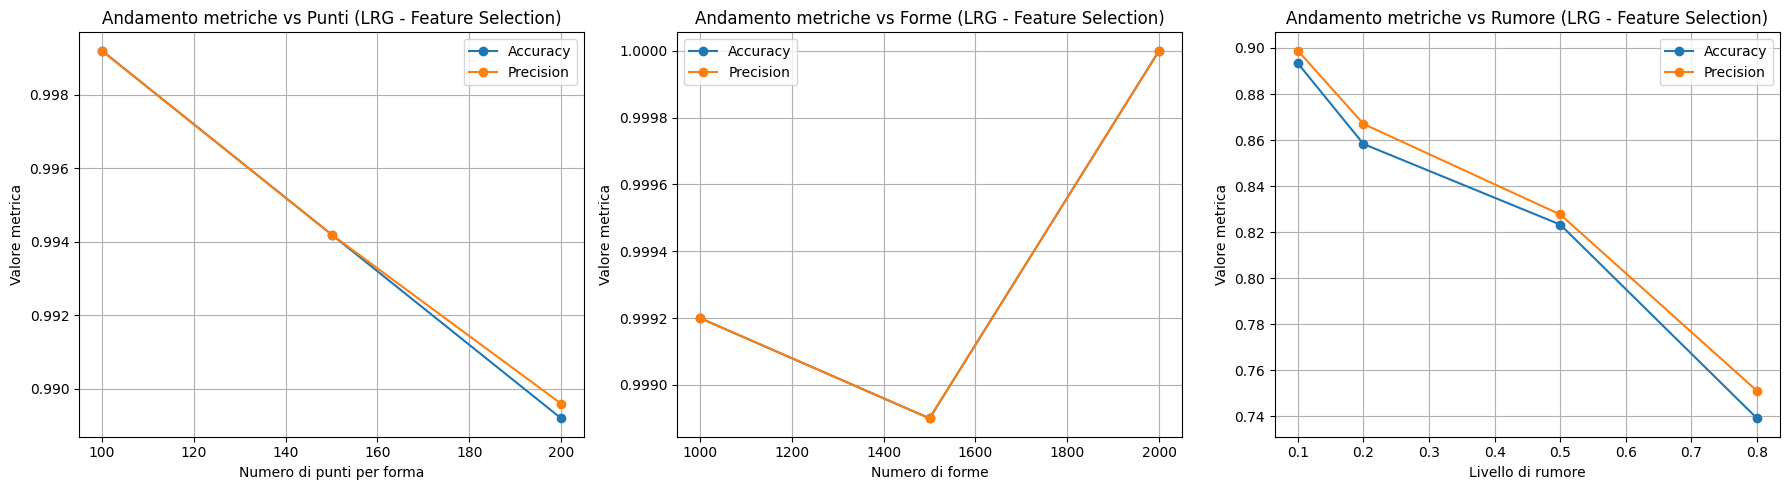

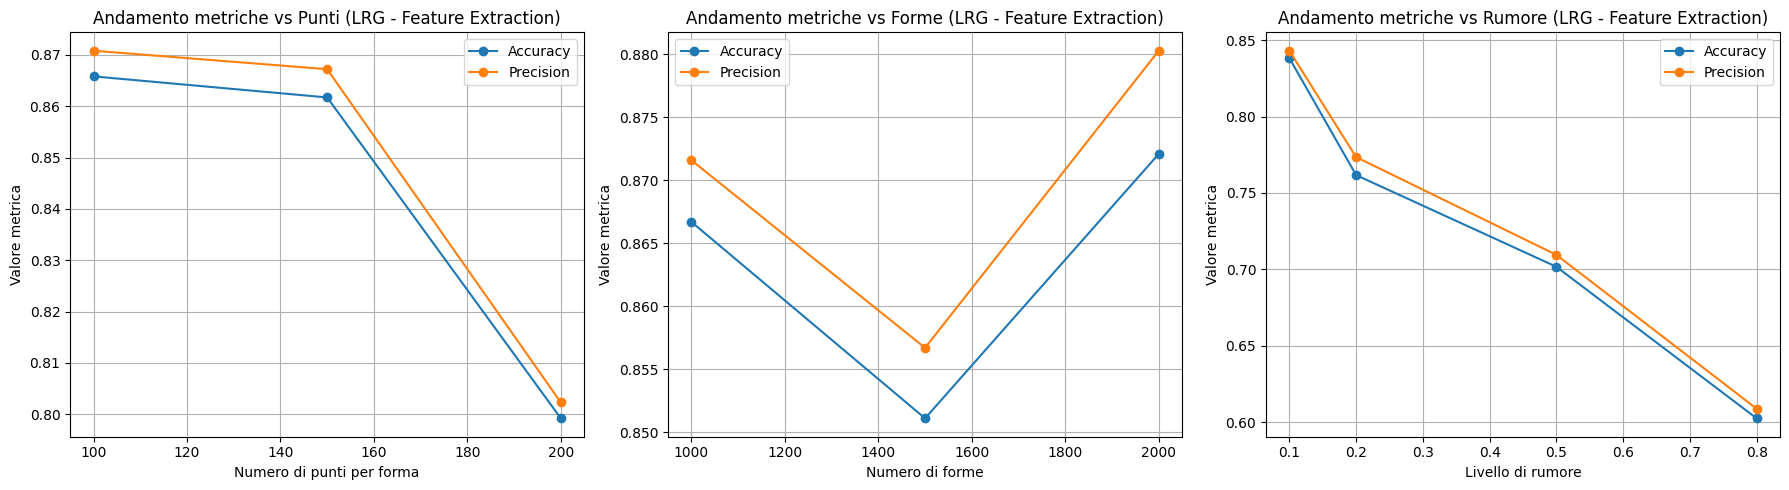

In [88]:
plot_figure(results=results_selection_lrg, title="LRG - Feature Selection")
plot_figure(results=results_pca_lrg, title="LRG - Feature Extraction")

In [89]:
results_selection_svm, results_pca_svm = test_robustezza_svm()

In [90]:
print_risultati(results_sel=results_selection_svm, results_pca=results_pca_svm)

[INFO]: Risultati modello feature selection:

Tipo di dataset: punti
0.9125 {'tipo': 'punti', 'forme': 1000, 'punti': 100, 'rumore': 0.0}
0.9058 {'tipo': 'punti', 'forme': 1000, 'punti': 150, 'rumore': 0.0}
0.915 {'tipo': 'punti', 'forme': 1000, 'punti': 200, 'rumore': 0.0}
Tipo di dataset: forme
0.9242 {'tipo': 'forme', 'forme': 1000, 'punti': 100, 'rumore': 0.0}
0.9217 {'tipo': 'forme', 'forme': 1500, 'punti': 100, 'rumore': 0.0}
0.9475 {'tipo': 'forme', 'forme': 2000, 'punti': 100, 'rumore': 0.0}
Tipo di dataset: rumore
0.8825 {'tipo': 'rumore', 'forme': 1000, 'punti': 100, 'rumore': 0.1}
0.87 {'tipo': 'rumore', 'forme': 1000, 'punti': 100, 'rumore': 0.2}
0.8367 {'tipo': 'rumore', 'forme': 1000, 'punti': 100, 'rumore': 0.5}
0.7633 {'tipo': 'rumore', 'forme': 1000, 'punti': 100, 'rumore': 0.8}

[INFO]: Risultati modello PCA:

Tipo di dataset: punti
0.8883 {'tipo': 'punti', 'forme': 1000, 'punti': 100, 'rumore': 0.0}
0.8883 {'tipo': 'punti', 'forme': 1000, 'punti': 150, 'rumore': 0.0}

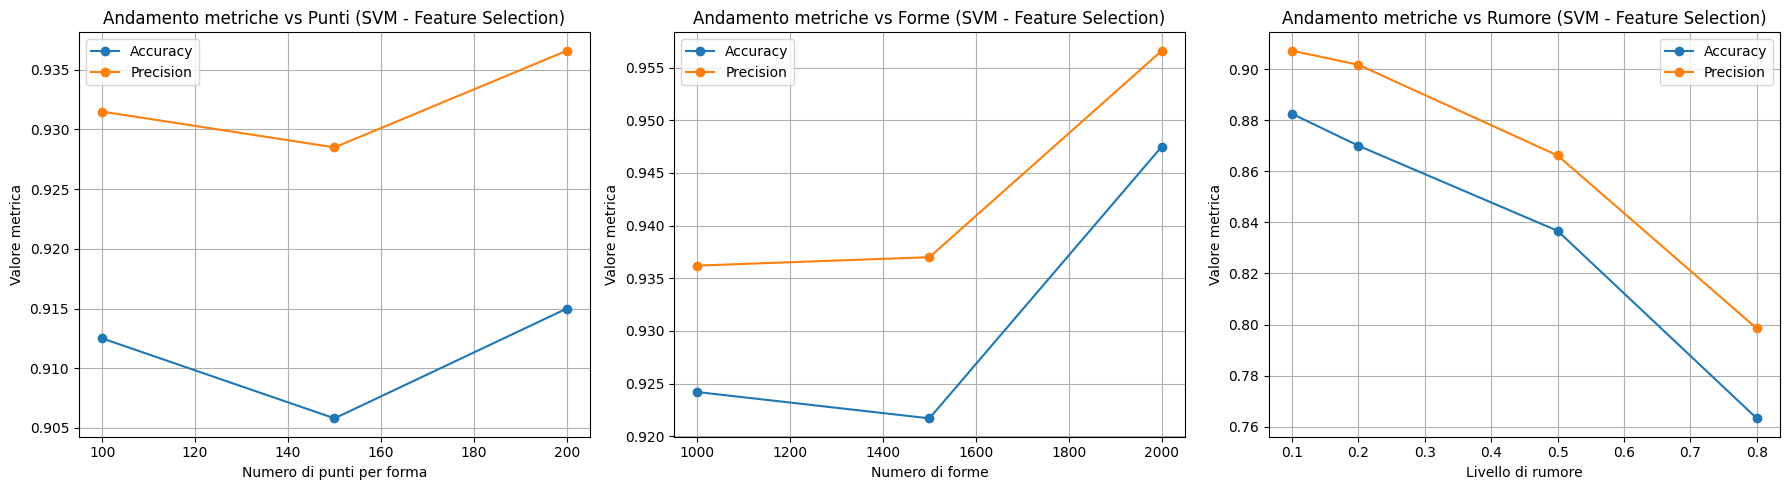

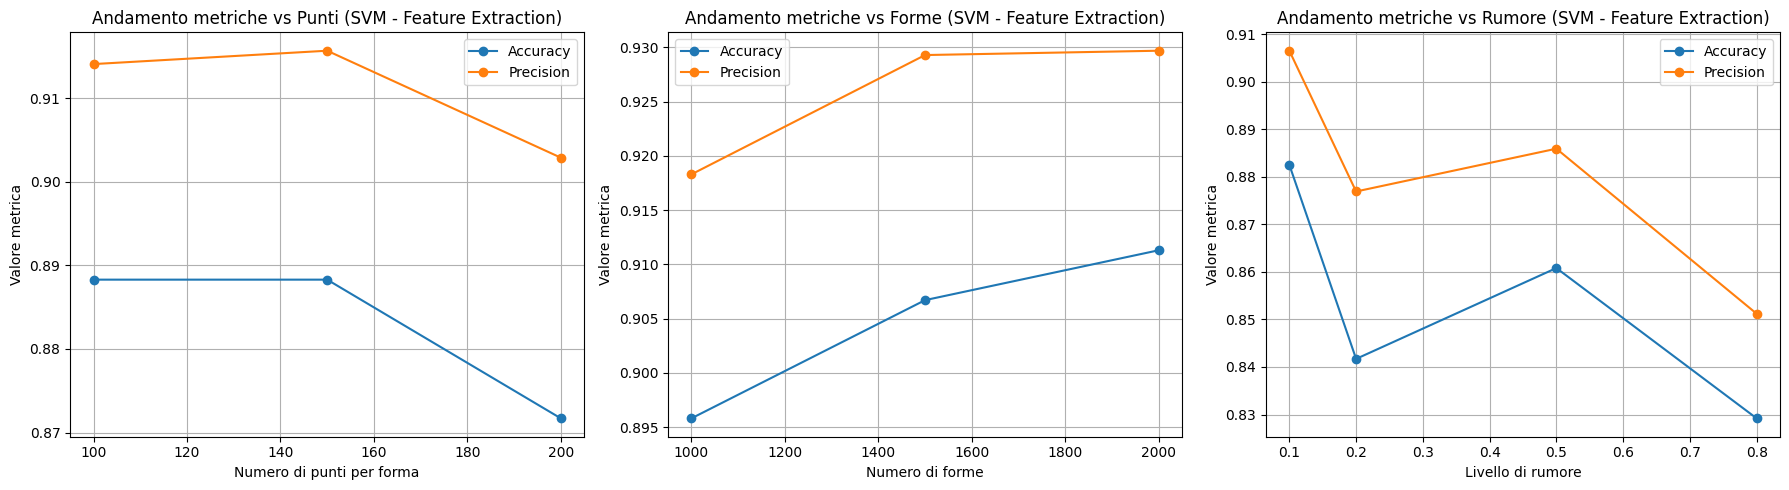

In [91]:
plot_figure(results=results_selection_svm, title="SVM - Feature Selection")
plot_figure(results=results_pca_svm, title="SVM - Feature Extraction")

## Classificazione Binaria

**Obiettivo Generale**
Lo scopo di questo codice è riformulare il problema di classificazione. Invece di chiedere al modello di identificare la forma specifica (ellisse, rettangolo, segmento, o croce), ora gli si chiede di rispondere a una domanda più fondamentale e concettualmente diversa:

"La forma geometrica ha un'area positiva o è una figura con area teoricamente nulla?"

Questo trasforma il problema da una classificazione multi-classe a una classificazione binaria.

In [92]:


y_bin = np.where((y == 2) | (y == 3), 0, 1)

labels_bin = ['Area Nulla', 'Area Positiva']

X , y = genera_campioni(n_shapes=1000, n_punti=100, rumore_std_bound=0.0)

print("Shape del nuovo dataset X:", X.shape)
print("Shape del nuovo dataset y:", y.shape)

X_f = ottieni_features(X)

print("Shape delle feature estratte:", X_f.shape)

X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(
    X_f, y_bin, test_size=0.3, random_state=42, stratify=y_bin
)

# 5. Stampa delle dimensioni dei set di addestramento e test
print("\n--- Set di dati per Classificazione Binaria ---")
print("Shape dei dati di addestramento (X_train_bin):", X_train_bin.shape)
print("Shape dei dati di test (X_test_bin):", X_test_bin.shape)
print("Shape delle etichette di addestramento (y_train_bin):", y_train_bin.shape)
print("Shape delle etichette di test (y_test_bin):", y_test_bin.shape)

Shape del nuovo dataset X: (4000, 100, 2)
Shape del nuovo dataset y: (4000,)
Shape delle feature estratte: (4000, 12)

--- Set di dati per Classificazione Binaria ---
Shape dei dati di addestramento (X_train_bin): (2800, 12)
Shape dei dati di test (X_test_bin): (1200, 12)
Shape delle etichette di addestramento (y_train_bin): (2800,)
Shape delle etichette di test (y_test_bin): (1200,)


**FORESTE**

**SELECTION E PCA**

In [93]:
# Split delle feature selezionate per la classificazione binaria
X_train_sel_bin, X_test_sel_bin, y_train_bin, y_test_bin = train_test_split(
	X_f, y_bin, test_size=0.3, random_state=42, stratify=y_bin
)

#Feature Selection
best_rf_sel = best_models_rf["Feature Selection"]
best_rf_sel.fit(X_train_sel_bin, y_train_bin)
y_pred_rf_sel = best_rf_sel.predict(X_test_sel_bin)

print("--- RandomForest su Feature Selection (Binario) ---")
print(classification_report(y_test_bin, y_pred_rf_sel, target_names=labels_bin))

# Split delle feature PCA per la classificazione binaria
# Usa le stesse feature estratte e PCA del problema binario
n_features_bin = 30
pca_bin = PCA(n_components=n_features_bin, svd_solver="randomized", whiten=True).fit(X_extraction)
X_pca_bin = pca_bin.transform(X_extraction)
X_train_pca_bin, X_test_pca_bin, y_train_pca_bin, y_test_pca_bin = train_test_split(
	X_pca_bin, y_bin, test_size=0.3, random_state=42, stratify=y_bin
)

# PCA
best_rf_pca = best_models_rf["PCA"]
best_rf_pca.fit(X_train_pca_bin, y_train_pca_bin)
y_pred_rf_pca = best_rf_pca.predict(X_test_pca_bin)

print("\n--- RandomForest su PCA (Binario) ---")
print(classification_report(y_test_pca_bin, y_pred_rf_pca, target_names=labels_bin))

--- RandomForest su Feature Selection (Binario) ---
               precision    recall  f1-score   support

   Area Nulla       1.00      1.00      1.00       600
Area Positiva       1.00      1.00      1.00       600

     accuracy                           1.00      1200
    macro avg       1.00      1.00      1.00      1200
 weighted avg       1.00      1.00      1.00      1200


--- RandomForest su PCA (Binario) ---
               precision    recall  f1-score   support

   Area Nulla       1.00      1.00      1.00       600
Area Positiva       1.00      1.00      1.00       600

     accuracy                           1.00      1200
    macro avg       1.00      1.00      1.00      1200
 weighted avg       1.00      1.00      1.00      1200



addestrare e valutare due modelli RandomForestClassifier distinti sul problema binario, per confrontare le performance delle due diverse rappresentazioni delle feature:

- Un modello addestrato sulle 12 feature geometriche ingegnerizzate.
- Un secondo modello addestrato sulle 30 componenti principali derivate dalla PCA.

L'uso del classification_report come metrica di valutazione fornirà un'analisi dettagliata delle performance, includendo precision, recall e F1-score per ciascuna delle due classi.

**CONFUSION MATRIX**

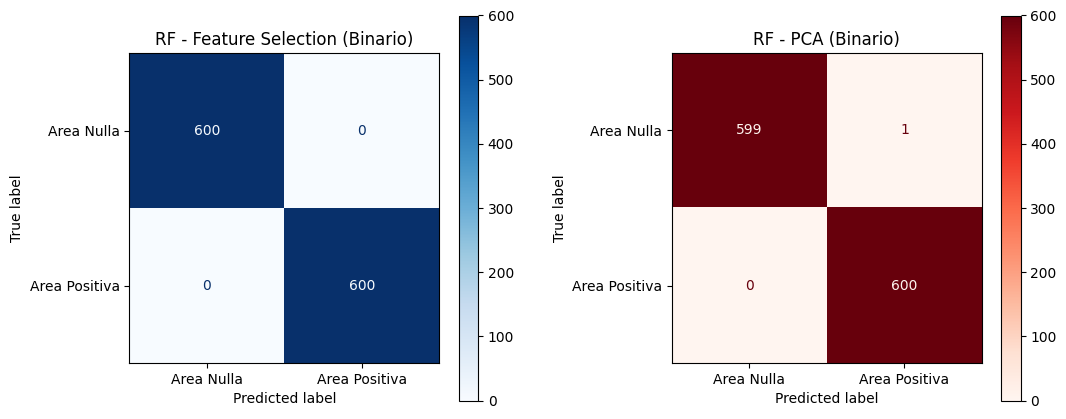

In [94]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Matrice per Feature Selection
ConfusionMatrixDisplay.from_predictions(
    y_test_bin, y_pred_rf_sel,
    display_labels=labels_bin,
    cmap="Blues",
    ax=axes[0]
)
axes[0].set_title("RF - Feature Selection (Binario)")

# Matrice per PCA
ConfusionMatrixDisplay.from_predictions(
    y_test_pca_bin, y_pred_rf_pca,
    display_labels=labels_bin,
    cmap="Reds",
    ax=axes[1]
)
axes[1].set_title("RF - PCA (Binario)")

plt.subplots_adjust(wspace=0.4)
plt.show()

**LOGISTIC REGRESSION**

**FEATURE SELECTION E PCA**

In [95]:
best_lrg_sel = best_models_lrg["Feature Selection"]
best_lrg_sel.fit(X_train_sel_bin, y_train_bin)
y_pred_lrg_sel = best_lrg_sel.predict(X_test_sel_bin)

print("--- Logistic Regression su Feature Selection (Binario) ---")
print(classification_report(y_test_bin, y_pred_lrg_sel, target_names=labels_bin))

best_lrg_pca = best_models_lrg["PCA"]
best_lrg_pca.fit(X_train_pca_bin, y_train_pca_bin)
y_pred_lrg_pca = best_lrg_pca.predict(X_test_pca_bin)

print("\n--- Logistic Regression su PCA (Binario) ---")
print(classification_report(y_test_pca_bin, y_pred_lrg_pca, target_names=labels_bin))

--- Logistic Regression su Feature Selection (Binario) ---
               precision    recall  f1-score   support

   Area Nulla       1.00      1.00      1.00       600
Area Positiva       1.00      1.00      1.00       600

     accuracy                           1.00      1200
    macro avg       1.00      1.00      1.00      1200
 weighted avg       1.00      1.00      1.00      1200


--- Logistic Regression su PCA (Binario) ---
               precision    recall  f1-score   support

   Area Nulla       1.00      1.00      1.00       600
Area Positiva       1.00      1.00      1.00       600

     accuracy                           1.00      1200
    macro avg       1.00      1.00      1.00      1200
 weighted avg       1.00      1.00      1.00      1200



**CONFUSION MATRIX**

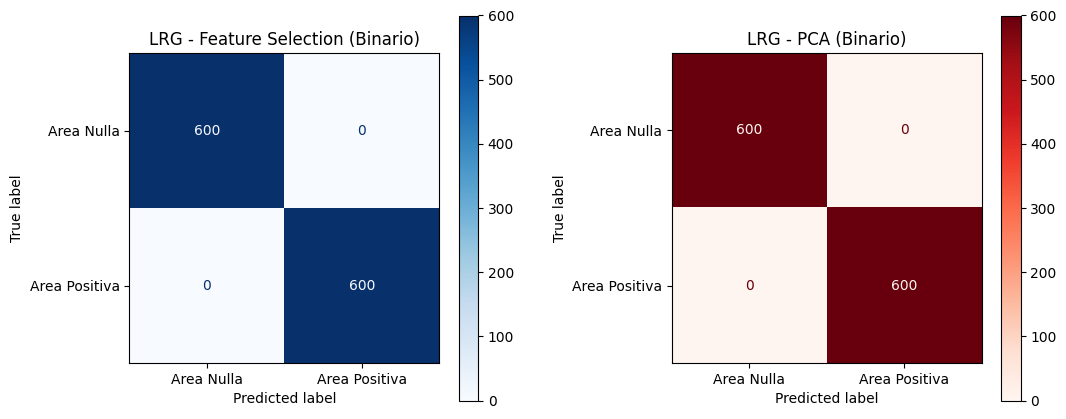

In [96]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Matrice per Feature Selection
ConfusionMatrixDisplay.from_predictions(
    y_test_bin, y_pred_lrg_sel,
    display_labels=labels_bin,
    cmap="Blues",
    ax=axes[0]
)
axes[0].set_title("LRG - Feature Selection (Binario)")

# Matrice per PCA
ConfusionMatrixDisplay.from_predictions(
    y_test_pca_bin, y_pred_lrg_pca,
    display_labels=labels_bin,
    cmap="Reds",
    ax=axes[1]
)
axes[1].set_title("LRG - PCA (Binario)")

plt.subplots_adjust(wspace=0.4)
plt.show()

**SVM**

**FEATURE SELECTION E PCA**

In [97]:
best_svm_sel = best_models_svm["Feature Selection"]
best_svm_sel.fit(X_train_sel_bin, y_train_bin)
y_pred_svm_sel = best_svm_sel.predict(X_test_sel_bin)

print("--- SVM su Feature Selection (Binario) ---")
print(classification_report(y_test_bin, y_pred_svm_sel, target_names=labels_bin))

# Modello con PCA
best_svm_pca = best_models_svm["PCA"]
best_svm_pca.fit(X_train_pca_bin, y_train_pca_bin)
y_pred_svm_pca = best_svm_pca.predict(X_test_pca_bin)

print("\n--- SVM su PCA (Binario) ---")
print(classification_report(y_test_pca_bin, y_pred_svm_pca, target_names=labels_bin))

--- SVM su Feature Selection (Binario) ---
               precision    recall  f1-score   support

   Area Nulla       1.00      1.00      1.00       600
Area Positiva       1.00      1.00      1.00       600

     accuracy                           1.00      1200
    macro avg       1.00      1.00      1.00      1200
 weighted avg       1.00      1.00      1.00      1200


--- SVM su PCA (Binario) ---
               precision    recall  f1-score   support

   Area Nulla       1.00      1.00      1.00       600
Area Positiva       1.00      1.00      1.00       600

     accuracy                           1.00      1200
    macro avg       1.00      1.00      1.00      1200
 weighted avg       1.00      1.00      1.00      1200



**CONFUSION MATRIX**

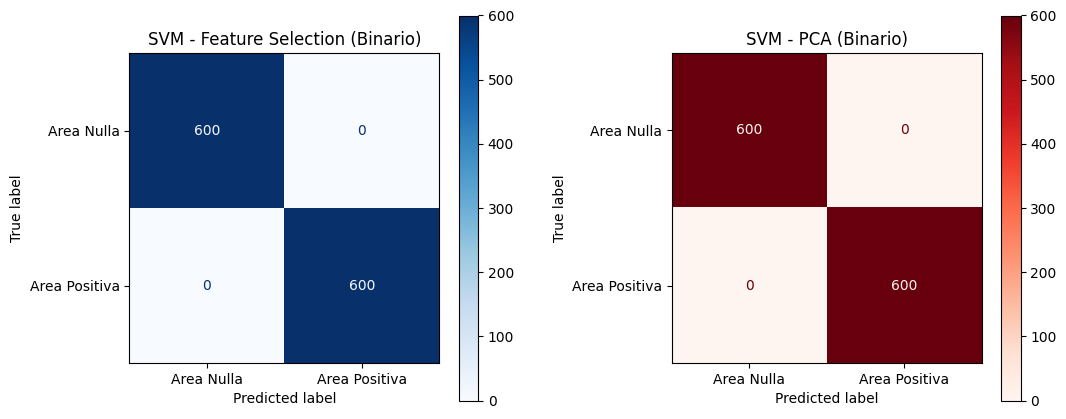

In [98]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Matrice per Feature Selection
ConfusionMatrixDisplay.from_predictions(
    y_test_bin, y_pred_svm_sel,
    display_labels=labels_bin,
    cmap="Blues",
    ax=axes[0]
)
axes[0].set_title("SVM - Feature Selection (Binario)")

# Matrice per PCA
ConfusionMatrixDisplay.from_predictions(
    y_test_pca_bin, y_pred_svm_pca,
    display_labels=labels_bin,
    cmap="Reds",
    ax=axes[1]
)
axes[1].set_title("SVM - PCA (Binario)")

plt.subplots_adjust(wspace=0.4)
plt.show()

**IMPORTANZA FEATURE**

Feature importances:
                    Feature  Importance       std
8         distanza_estremi    0.267472  0.101212
2            rapporto_aree    0.207820  0.134119
10            eccentricità    0.200161  0.092680
7             min_distanze    0.078125  0.093892
1            area_convessa    0.068055  0.079044
0                     area    0.039016  0.064894
3                perimetro    0.035569  0.036108
4           media_distanze    0.033278  0.035330
5             std_distanze    0.021790  0.026045
11  distanza_massima_punti    0.020749  0.024406
6             max_distanze    0.020110  0.025542
9             aspect_ratio    0.007855  0.013962


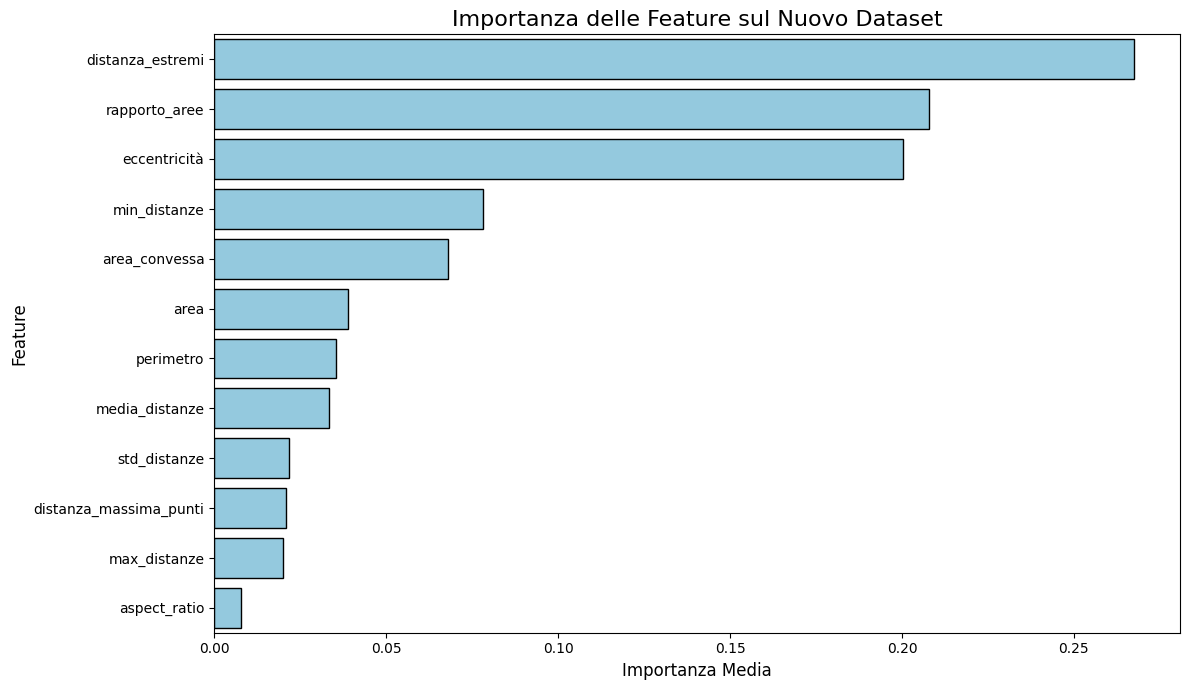

In [99]:
# Creazione e addestramento del modello per la feature selection
forest_new = ExtraTreesClassifier(n_estimators=250, random_state=0)
forest_new.fit(X_f, y)

# Nomi delle feature utilizzate per il plot
feature_names = [
    'area', 'area_convessa', 'rapporto_aree', 'perimetro',
    'media_distanze', 'std_distanze', 'max_distanze', 'min_distanze',
    'distanza_estremi', 'aspect_ratio', 'eccentricità', 'distanza_massima_punti'
]

# Calcolo dell'importanza media e della deviazione standard
importances = forest_new.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest_new.estimators_], axis=0)

# Creazione di un DataFrame per la visualizzazione
df_importance = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances,
    "std": std
}).sort_values(by="Importance", ascending=False)
print("Feature importances:\n", df_importance)

# Plot delle feature importances
plt.figure(figsize=(12, 7))
sns.barplot(data=df_importance, x="Importance", y="Feature", color='skyblue', edgecolor='black')
plt.title('Importanza delle Feature sul Nuovo Dataset', fontsize=16)
plt.xlabel('Importanza Media', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.show()

**ANALISI ACCURACY in base al # Features**

Accuratezza per numero di feature selezionate: [0.78, 0.91, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


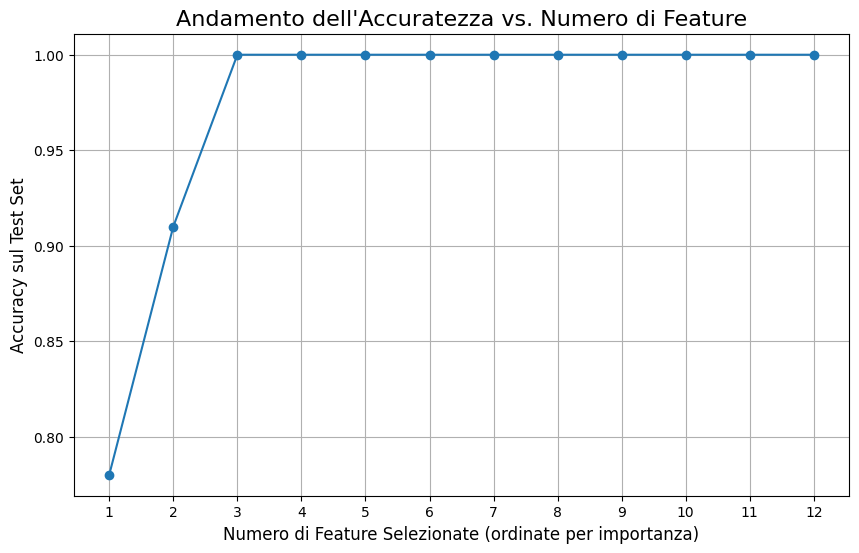

In [100]:
# Ordinamento delle feature per importanza
idx_sorted_new = np.argsort(importances)[::-1]

accuracies_new = []
feature_range = range(1, len(feature_names) + 1)

# Ciclo per testare l'accuratezza con un numero crescente di feature
for k in feature_range:
    # Selezione delle top k feature
    X_k_features = X_f[:, idx_sorted_new[:k]]
    
    # Suddivisione del dataset ridotto
    X_train_k, X_test_k, y_train_k, y_test_k = train_test_split(X_k_features, y, test_size=0.3, random_state=42, stratify=y)
    
    # Addestramento e valutazione del classificatore
    clf_k = RandomForestClassifier(random_state=42)
    clf_k.fit(X_train_k, y_train_k)
    y_pred_k = clf_k.predict(X_test_k)
    acc_k = accuracy_score(y_test_k, y_pred_k)
    accuracies_new.append(acc_k)

print("Accuratezza per numero di feature selezionate:", accuracies_new)

# Plot dell'andamento dell'accuratezza
plt.figure(figsize=(10, 6))
plt.plot(feature_range, accuracies_new, marker='o', linestyle='-')
plt.xlabel('Numero di Feature Selezionate (ordinate per importanza)', fontsize=12)
plt.ylabel('Accuracy sul Test Set', fontsize=12)
plt.title('Andamento dell\'Accuratezza vs. Numero di Feature', fontsize=16)
plt.grid(True)
plt.xticks(feature_range)
plt.show()